# Import data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [3, 3]
plt.rcParams['figure.dpi'] = 300

loc = {1: "GO", -1: "PM"}
loc_name = ["GO", "PM"]


def df2Xy(df):
    n_data, n_features = len(df), len(df.T)
    X = np.array(df.iloc[:, 2:(n_features)])  # inputs
    #X = np.where(X>0,1,0) # trasform data into presence-absence of the species
    y = np.array(df.iloc[:, 1], int)  # labels
    return X, y, df.columns[2:]


####### Gills:
df_S18_br = pd.read_csv(
    "Feature-table_Postdepuration_tissue_br-E18_FilterThreshold0.05_binary.csv",
    sep=",")
df_S19_br = pd.read_csv(
    "Feature-table_Postdepuration_tissue_br-E19_FilterThreshold0.05_binary.csv",
    sep=",")

df_W19_br = pd.read_csv(
    "Feature-table_Postdepuration_tissue_br-I19_FilterThreshold0.05_binary.csv",
    sep=",")
df_W20_br = pd.read_csv(
    "Feature-table_Postdepuration_tissue_br-I20_FilterThreshold0.05_binary.csv",
    sep=",")

#df_W19_br = df_W19_br[df_W19_br.Classe != 4]
#df_W20_br = df_W20_br[df_W20_br.Classe != 7]

# Take unions
df_V_br = pd.concat([df_S18_br, df_W19_br], ignore_index=True, sort=False).fillna(0)
df_L_br = pd.concat([df_S19_br, df_W20_br], ignore_index=True, sort=False).fillna(0)

######## Hepatopancreas:
df_S18_gh = pd.read_csv(
    "Feature-table_Postdepuration_tissue_gh-E18_FilterThreshold0.05_binary.csv",
    sep=",")
df_S19_gh = pd.read_csv(
    "Feature-table_Postdepuration_tissue_gh-E19_FilterThreshold0.05_binary.csv",
    sep=",")

df_W19_gh = pd.read_csv(
    "Feature-table_Postdepuration_tissue_gh-I19_FilterThreshold0.05_binary.csv",
    sep=",")
df_W20_gh = pd.read_csv(
    "Feature-table_Postdepuration_tissue_gh-I20_FilterThreshold0.05_binary.csv",
    sep=",")

#df_W19_gh = df_W19_gh[df_W19_gh.Classe != 7]
#df_W20_gh = df_W20_gh[df_W20_gh.Classe != 7]

# Take unions
df_V_gh = pd.concat([df_S18_gh, df_W19_gh], ignore_index=True, sort=False).fillna(0)
df_L_gh = pd.concat([df_S19_gh, df_W20_gh], ignore_index=True, sort=False).fillna(0)

########## Make train and test
XL_br, yL_br, otu_names_br = df2Xy(df_L_br)
XV_br, yV_br, otu_names_br = df2Xy(df_V_br)
print("branchie - dimensioni dataframes: ", df_L_br.shape, df_V_br.shape, XL_br.shape, XV_br.shape, otu_names_br.shape)

XL_gh, yL_gh, otu_names_gh = df2Xy(df_L_gh)
XV_gh, yV_gh, otu_names_gh = df2Xy(df_V_gh)
print("ghiandola digestiva - dimensioni dataframes: ", df_L_gh.shape,
      df_V_gh.shape, otu_names_gh.shape)

branchie - dimensioni dataframes:  (20, 226) (20, 226) (20, 224) (20, 224) (224,)
ghiandola digestiva - dimensioni dataframes:  (20, 230) (20, 230) (228,)


In [2]:
df_S18_br.shape, df_S19_br.shape, df_W19_br.shape, df_W20_br.shape

((10, 202), (10, 202), (10, 64), (10, 64))

In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score
from sklearn.ensemble import BaggingClassifier
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import itertools


def plot_cm(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, output_pdf_path=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    The figure can be saved as a PDF by specifying `output_pdf_path`.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if output_pdf_path: #Part edited with chatGPT
        plt.savefig(output_pdf_path, format='pdf')
    plt.show()

# Example usage:
# cm = np.array([[5, 2], [3, 10]])  # Example confusion matrix
# classes = ['Class 1', 'Class 2']
# plot_cm(cm, classes, normalize=True, output_pdf_path='confusion_matrix.pdf')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

def plot_feature_importance(importance,names,showcategories,model_type, file_name=""):
    '''This function plots the n more important categories defined by the model in the fitting phase. It also saves a .csv file with the taxonomy associated with each OTU and its importance in the model.'''

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
#    #Merge with taxonomy database of names:
#    fi_df = pd.merge(fi_df, names.to_frame(), left_on='feature_names', right_on='OTU_ID')
#    #Concatenate OTU_ID with taxonomy:
#    fi_df['combined'] = fi_df['OTU_ID'].astype(str)+" | "+fi_df['Taxon']

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Export to csv:
    fi_df.to_csv(file_name+".csv")
    
    #Keep only n top categories:
    fi_df = fi_df.head(n=showcategories)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.tight_layout()
    plt.savefig(file_name+".pdf")


# Start cross-validation on second year ##

## Gills:

param= 1500 12

K-score= 1.0 
##########
param= 2000 12

K-score= 1.0 
##########
param= 1500 16

K-score= 1.0 
##########
param= 2000 16

K-score= 1.0 
##########
param= 1500 18

K-score= 1.0 
##########
param= 2000 18

K-score= 1.0 
##########
best= (2000, 18)
>>>               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20
 
K-score= 1.0 
##########
Confusion matrix, without normalization
[[10  0]
 [ 0 10]]


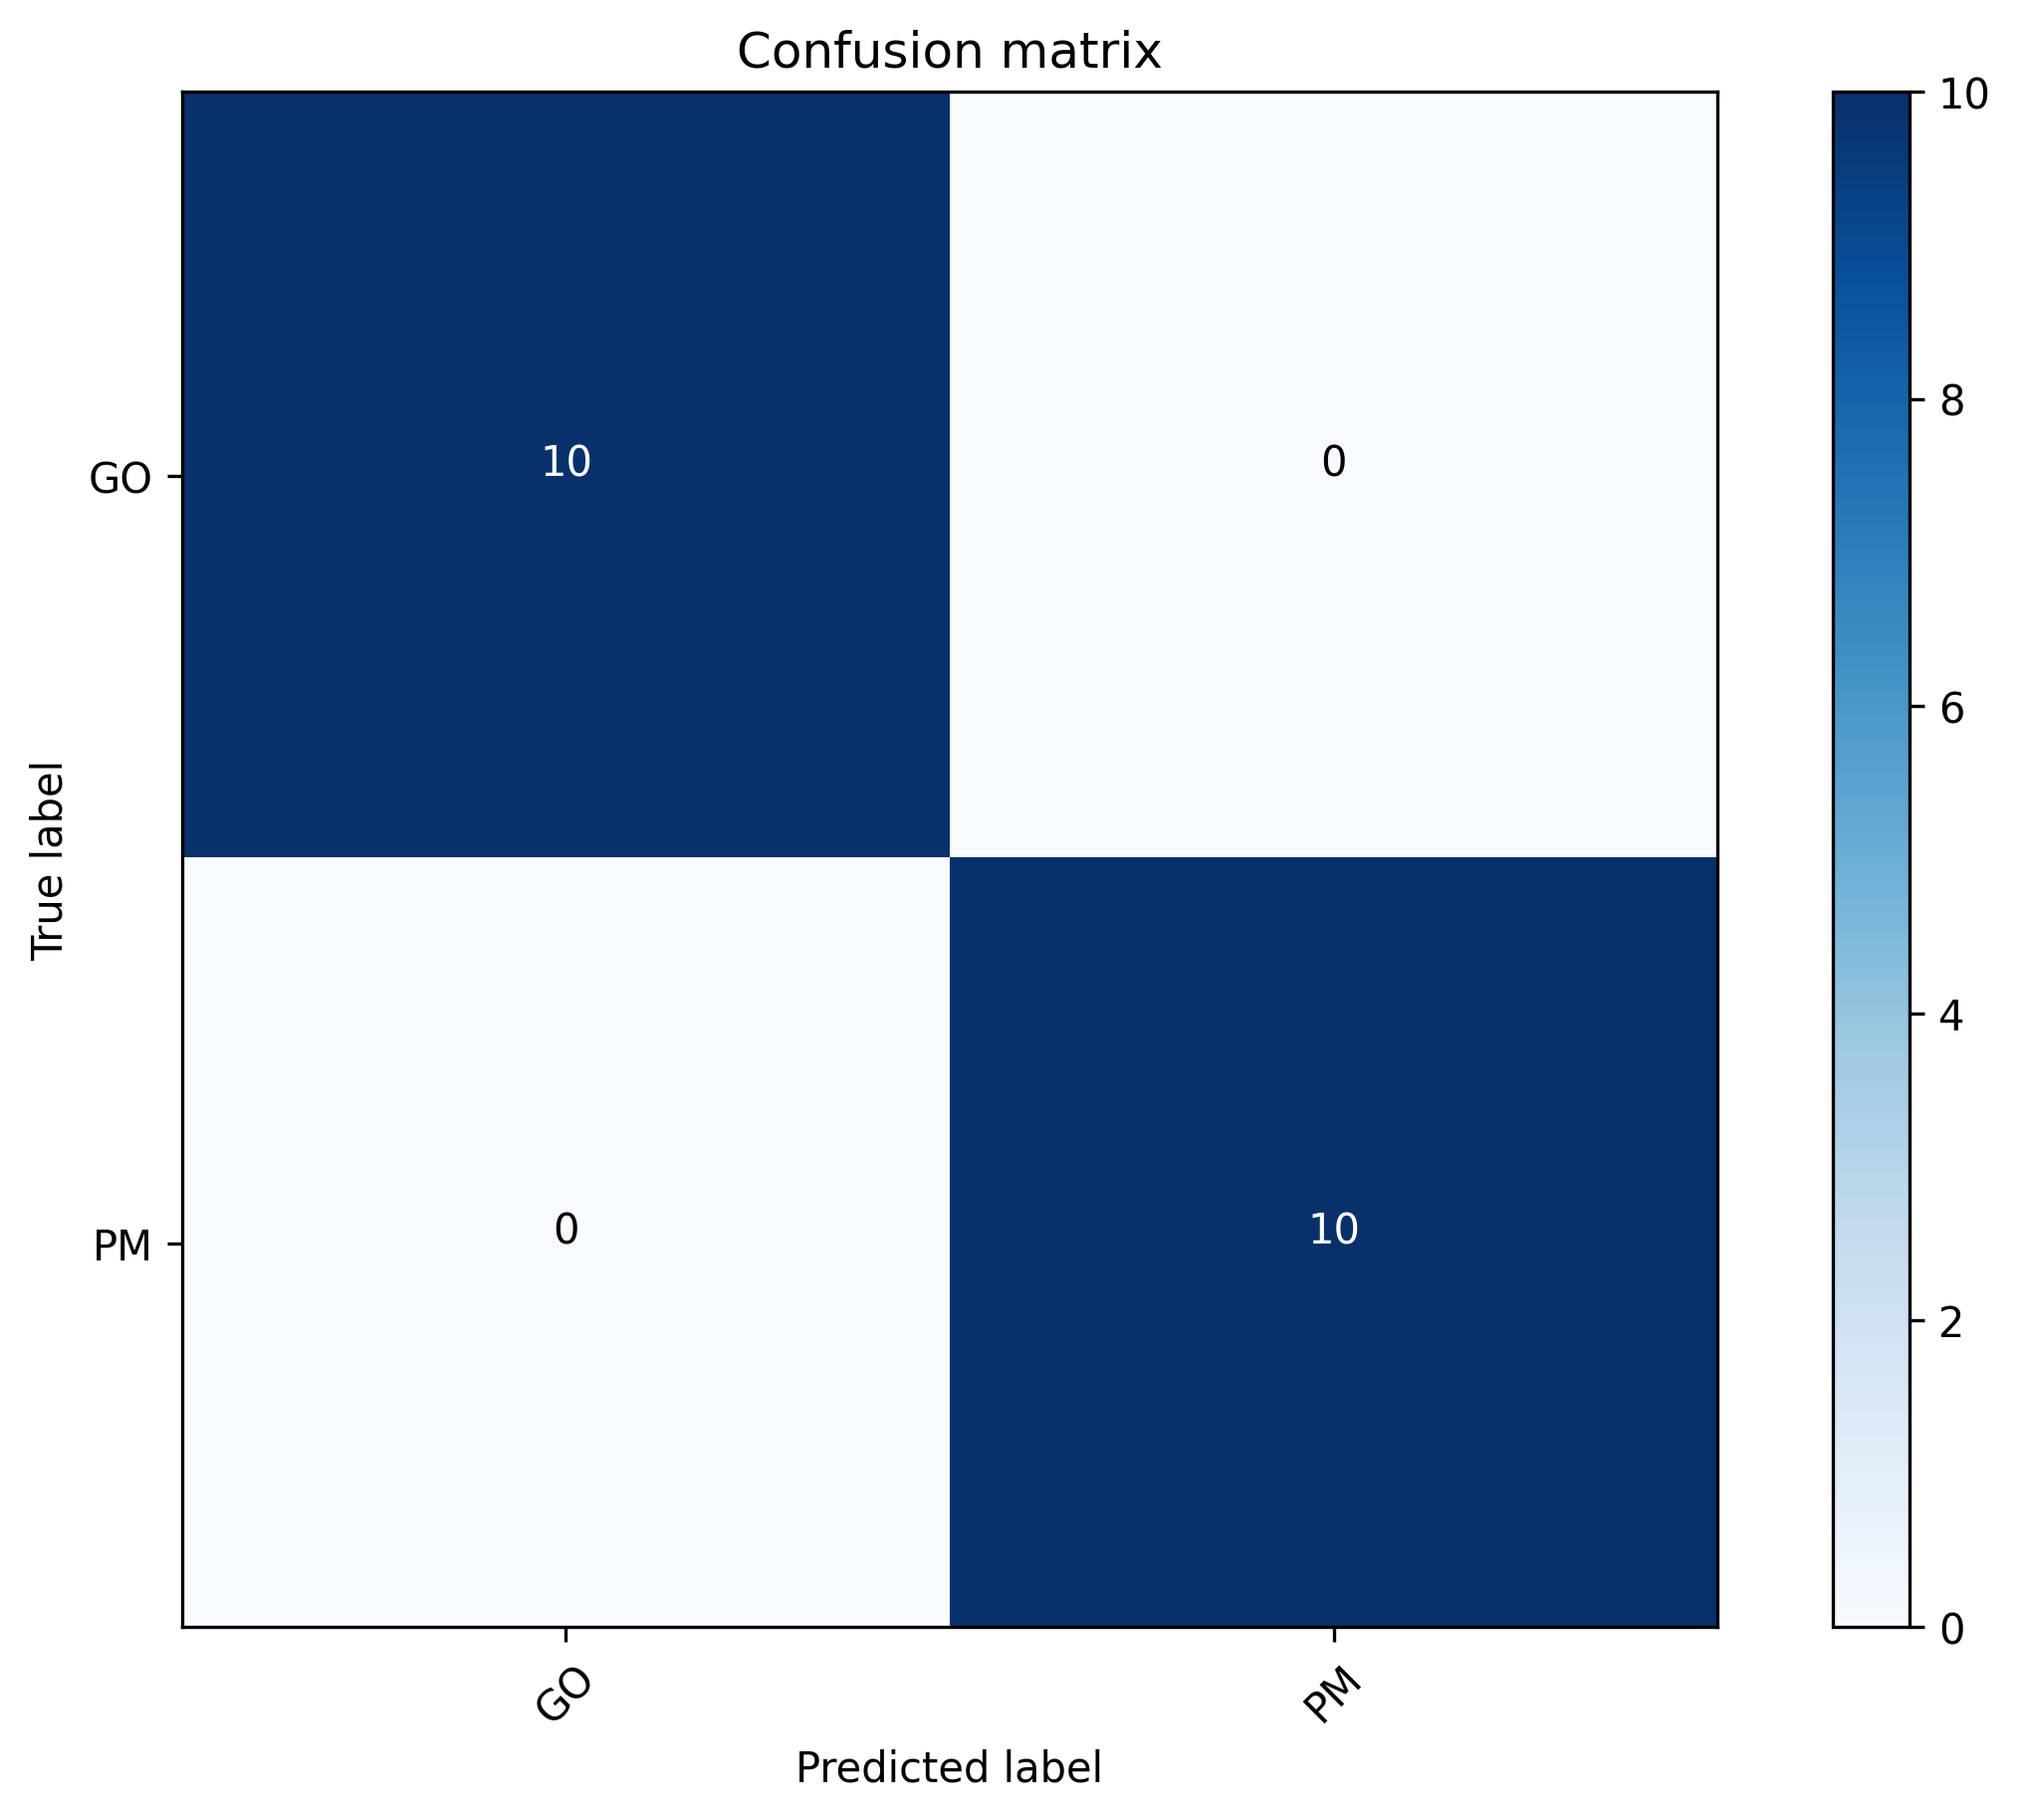

best= (2000, 18)


In [5]:
X_br, y_br = XL_br, yL_br 
cv_br = KFold(n_splits=20)
bscore_br= -1
abest_br=0.1
ne_br = 10 # to be tested
cval_br = 1.0
ms_br = 1.0 # to be tested
bobs_br, bpred_br = [], []
for md_br in [12,16,18]: 
    for ne_br in [1500, 2000]:    
        print("param=", ne_br, md_br)
        clf_br = RandomForestClassifier(n_estimators=ne_br, max_depth=md_br)
        pred_br, pred_prob_br, obs_br =[], [], []
        for train_index, test_index in cv_br.split(X_br):
            #print("TRAIN:", train_index, ",TEST:", test_index)
            X_train, X_test = X_br[train_index], X_br[test_index]
            y_train, y_test = y_br[train_index], y_br[test_index]
            clf_br.fit(X_train, y_train)
            pred_br.extend(clf_br.predict(X_test))
            obs_br.extend(y_test)
        score_br = cohen_kappa_score(obs_br,pred_br)
        if score_br >= bscore_br:
            bscore_br = score_br
            abest_br = ne_br,md_br
            bobs_br = obs_br[:]
            bpred_br = pred_br[:]
        #print("mf=",mf,classification_report(obs,pred),
        print("\nK-score=",cohen_kappa_score(obs_br,pred_br),"\n"+"#"*10) 

print("best=",abest_br)

# Assess the goodness of the chosen parameters:
print(">>>",classification_report(bobs_br,bpred_br),
          "\nK-score=",cohen_kappa_score(bobs_br,bpred_br),
          "\n"+"#"*10)
cnf_matrix = confusion_matrix(bobs_br, bpred_br)
plot_cm(cnf_matrix, classes=loc_name)
plt.show()        
print("best=",abest_br)

## Digestive gland:

param= 1500 12

K-score= 1.0 
##########
param= 2000 12

K-score= 1.0 
##########
param= 1500 16

K-score= 1.0 
##########
param= 2000 16

K-score= 1.0 
##########
param= 1500 18

K-score= 1.0 
##########
param= 2000 18

K-score= 1.0 
##########
best= (2000, 18)
>>>               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20
 
K-score= 1.0 
##########
Confusion matrix, without normalization
[[10  0]
 [ 0 10]]


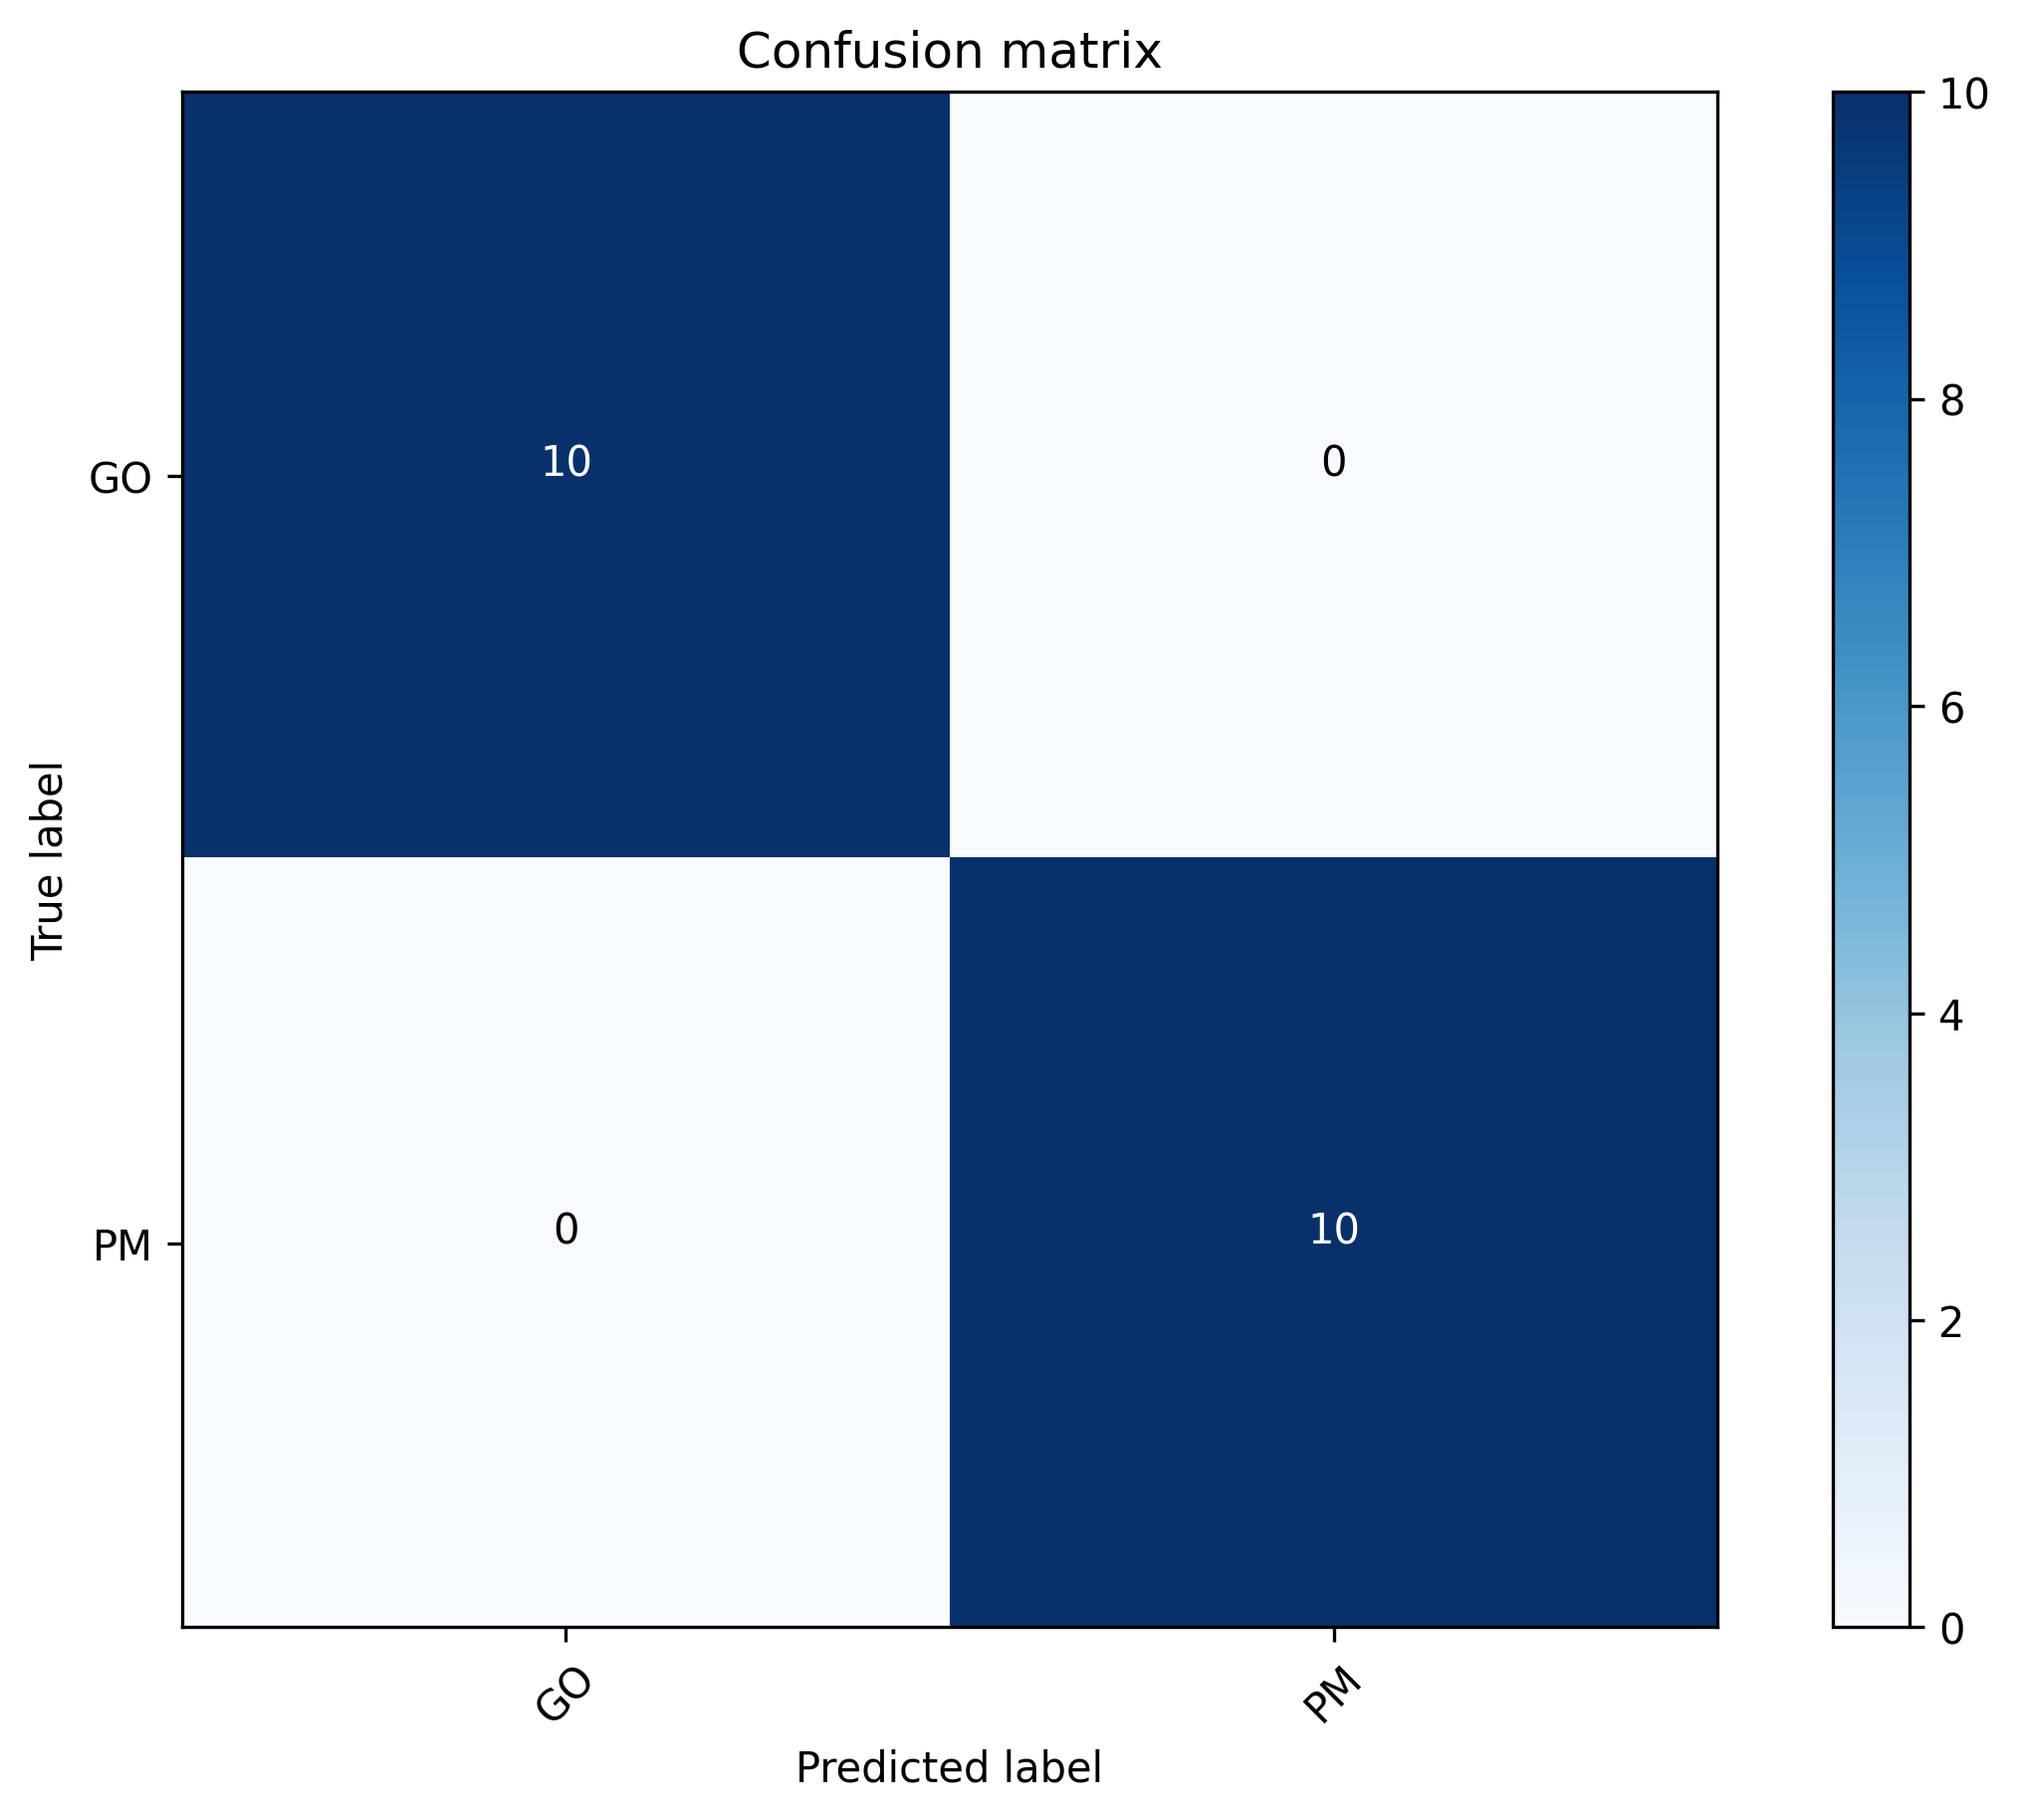

best= (2000, 18)


In [6]:
X_gh, y_gh = XL_gh, yL_gh 
cv_gh = KFold(n_splits=20)
bscore_gh= -1
abest_gh=0.1
ne_gh = 10 # to be tested
cval_gh = 1.0
ms_gh = 1.0 # to be tested
bobs_gh, bpred_gh = [], []
#model = linear_model.LogisticRegression(penalty='l1', fit_intercept=True, C=cval, solver="liblinear",max_iter=1000)
for md_gh in [12,16,18]: 
    for ne_gh in [1500, 2000]:    
        print("param=", ne_gh, md_gh)
        clf_gh = RandomForestClassifier(n_estimators=ne_gh, max_depth=md_gh)
        pred_gh, pred_prob_gh, obs_gh =[], [], []
        for train_index, test_index in cv_gh.split(X_gh):
            #print("TRAIN:", train_index, ",TEST:", test_index)
            X_train, X_test = X_gh[train_index], X_gh[test_index]
            y_train, y_test = y_gh[train_index], y_gh[test_index]
            clf_gh.fit(X_train, y_train)
            pred_gh.extend(clf_gh.predict(X_test))
            obs_gh.extend(y_test)
        score_gh = cohen_kappa_score(obs_gh,pred_gh)
        if score_gh >= bscore_gh:
            bscore_gh = score_gh
            abest_gh = ne_gh,md_gh
            bobs_gh = obs_gh[:]
            bpred_gh = pred_gh[:]
        #print("mf=",mf,classification_report(obs,pred),
        print("\nK-score=",cohen_kappa_score(obs_gh,pred_gh),"\n"+"#"*10) 

print("best=",abest_gh)

# Assess the goodness of the chosen parameters:
print(">>>",classification_report(bobs_gh,bpred_gh),
          "\nK-score=",cohen_kappa_score(bobs_gh,bpred_gh),
          "\n"+"#"*10)
cnf_matrix = confusion_matrix(bobs_gh, bpred_gh)
plot_cm(cnf_matrix, classes=loc_name)
plt.show()        
print("best=",abest_gh)

---------------------------------------
# Fit using second year data, predict first year data

## Gills:

 All sets
>>> Xs19               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20
 
ROC AUC= 1.0 
##########
Confusion matrix, without normalization
[[10  0]
 [ 0 10]]


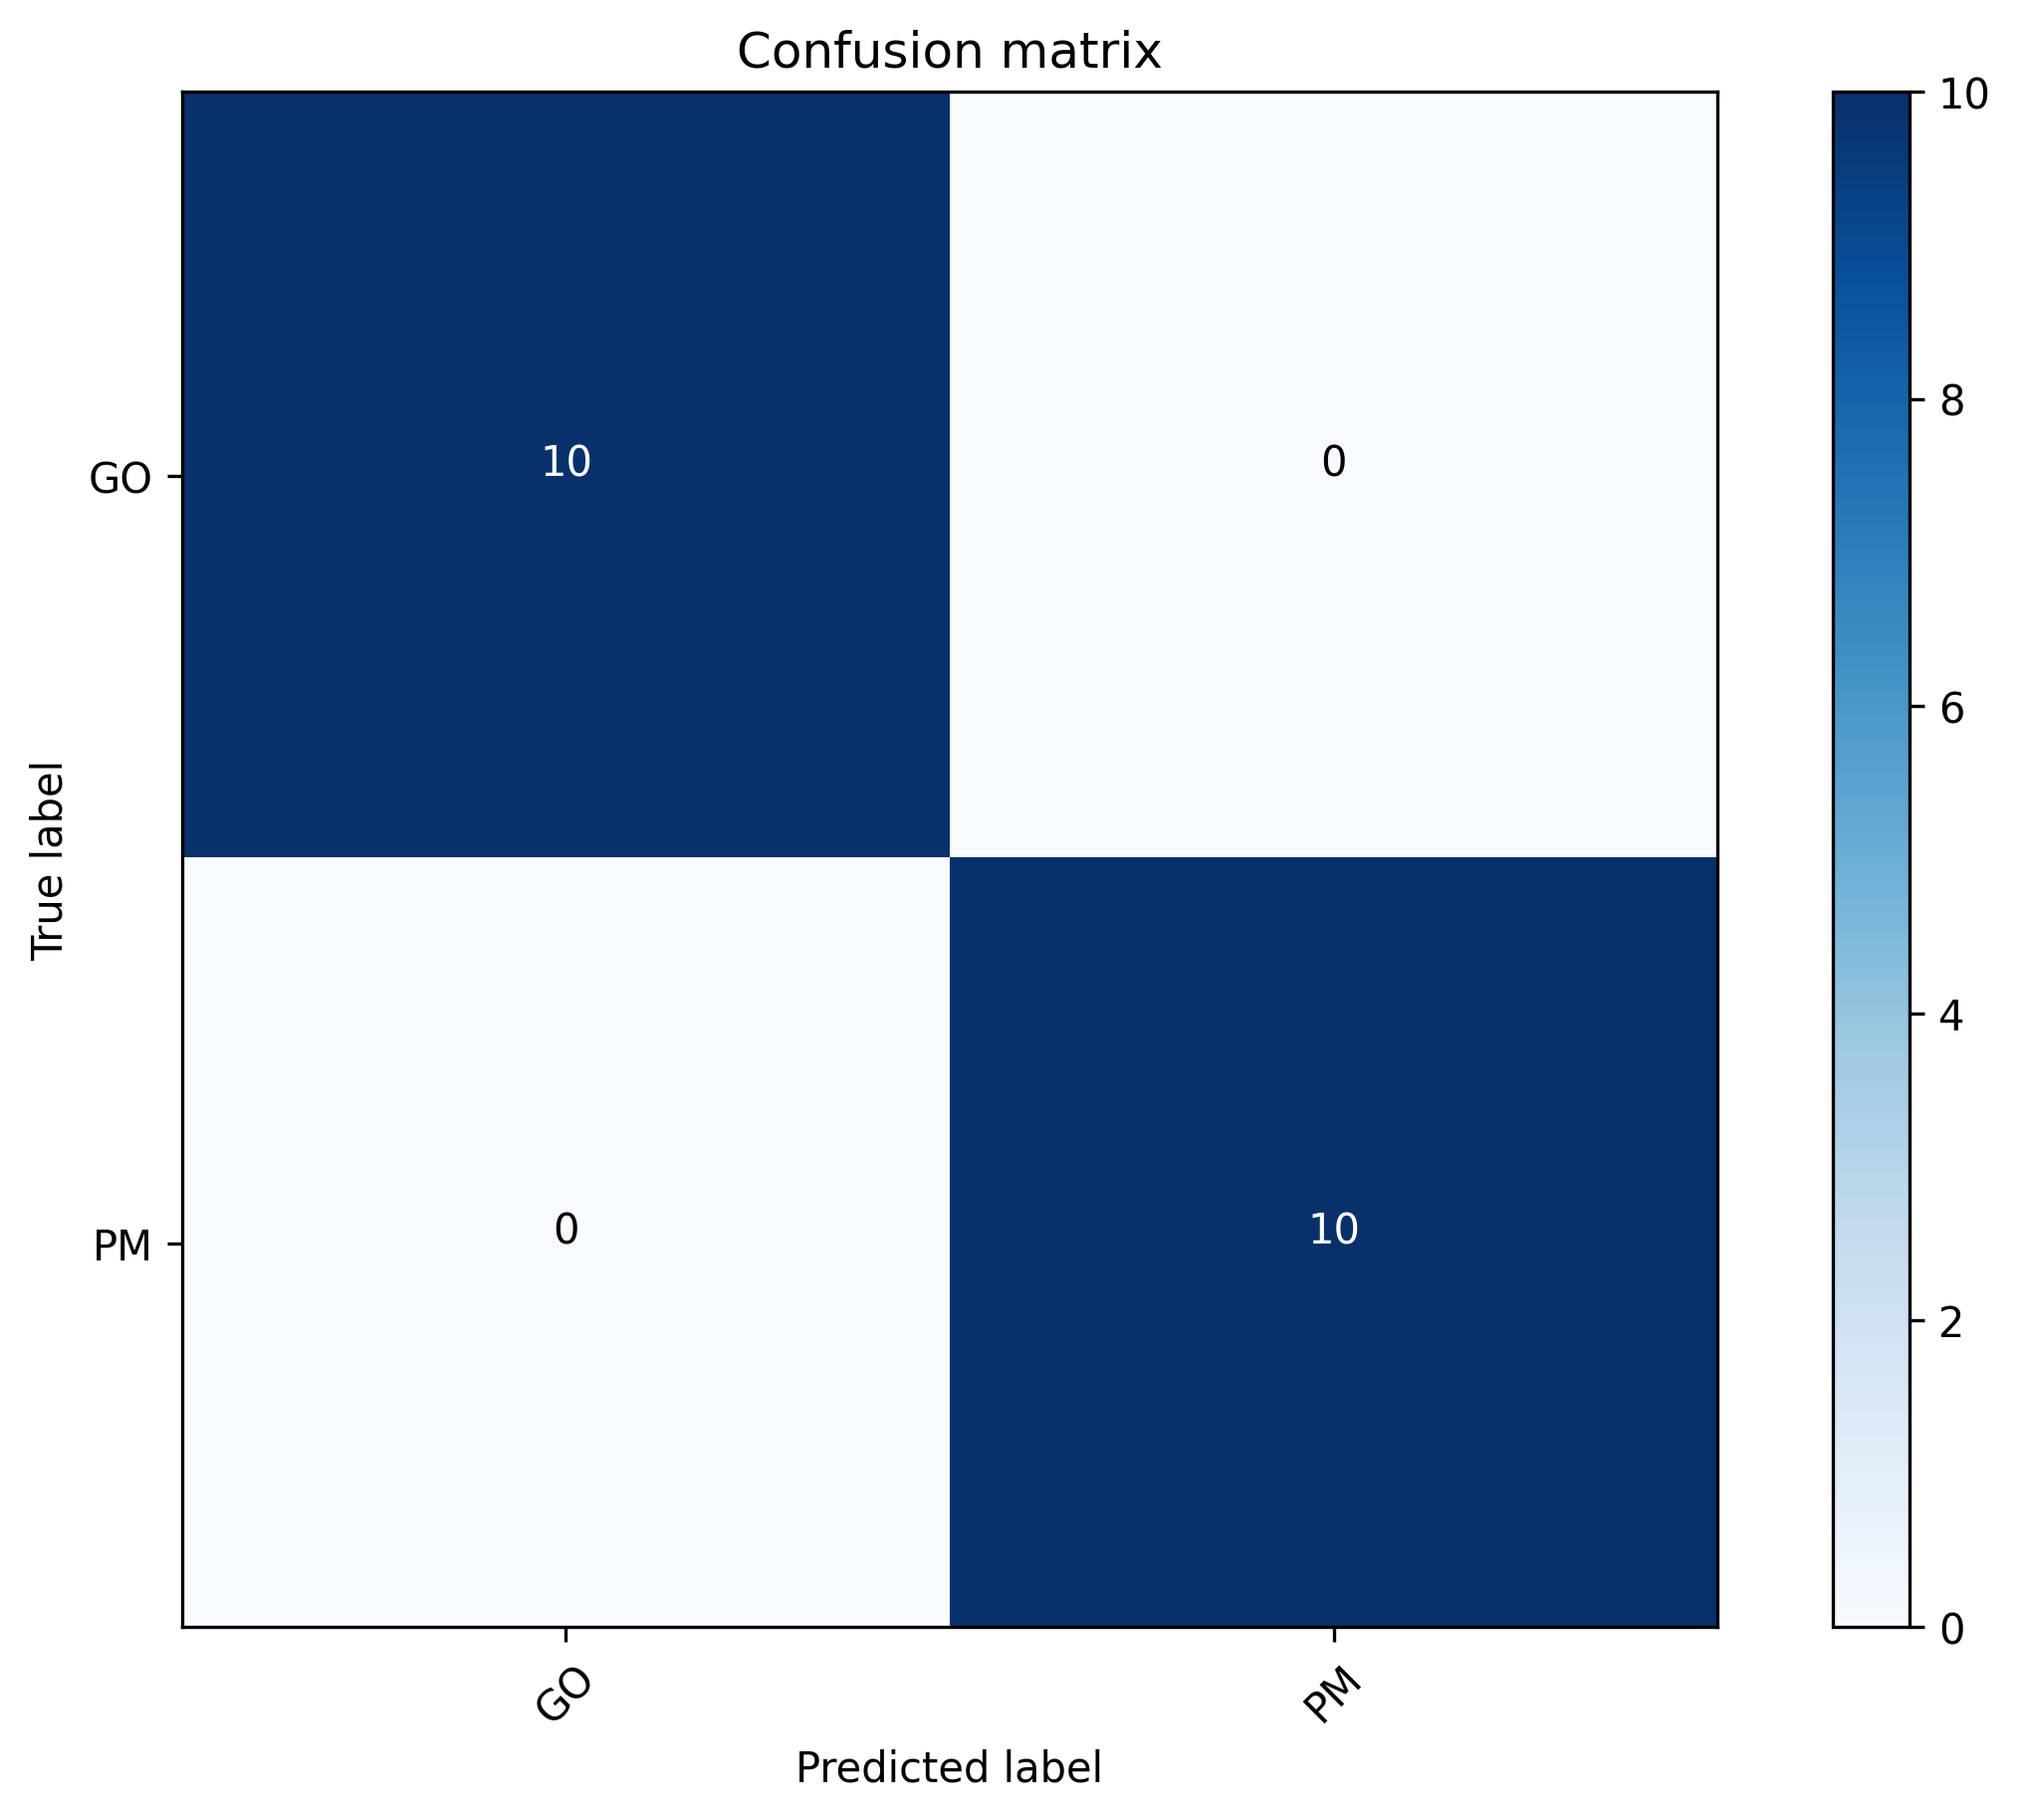

In [7]:
ne_br, md_br = abest_br # best paramenters
clf_br = clf_br = RandomForestClassifier(n_estimators=ne_br, max_depth=md_br)

np.random.seed(42)
clf_br.fit(XL_br,yL_br) # Fit using second year data.

print ("="*20,"\n","All sets\n","="*20) 
p_br_proba = clf_br.predict_proba(XV_br) # Predict using first year data. Returns probabilities! Useful for summing later on.
p_br = clf_br.predict(XV_br) # Predict using first year data. Returns classes.
#pred_br = np.argmax( np.vstack([np.sum(p_br[:,[0,1]],axis=1), np.sum(p_br[:,[2,3]],axis=1)]).T, axis=1)
#obs2_br = np.where(np.array(yV_br)<=2,0,1)



print(">>> Xs19",classification_report(yV_br,p_br),
          #"\nK-score=",cohen_kappa_score(yV_br,p_br),
          "\nROC AUC=", roc_auc_score(yV_br,p_br),
          "\n"+"#"*10)
cnf_matrix_br = confusion_matrix(yV_br,p_br)
plot_cm(cnf_matrix_br, classes=loc_name, output_pdf_path="Branchie_pred_first_year.pdf")

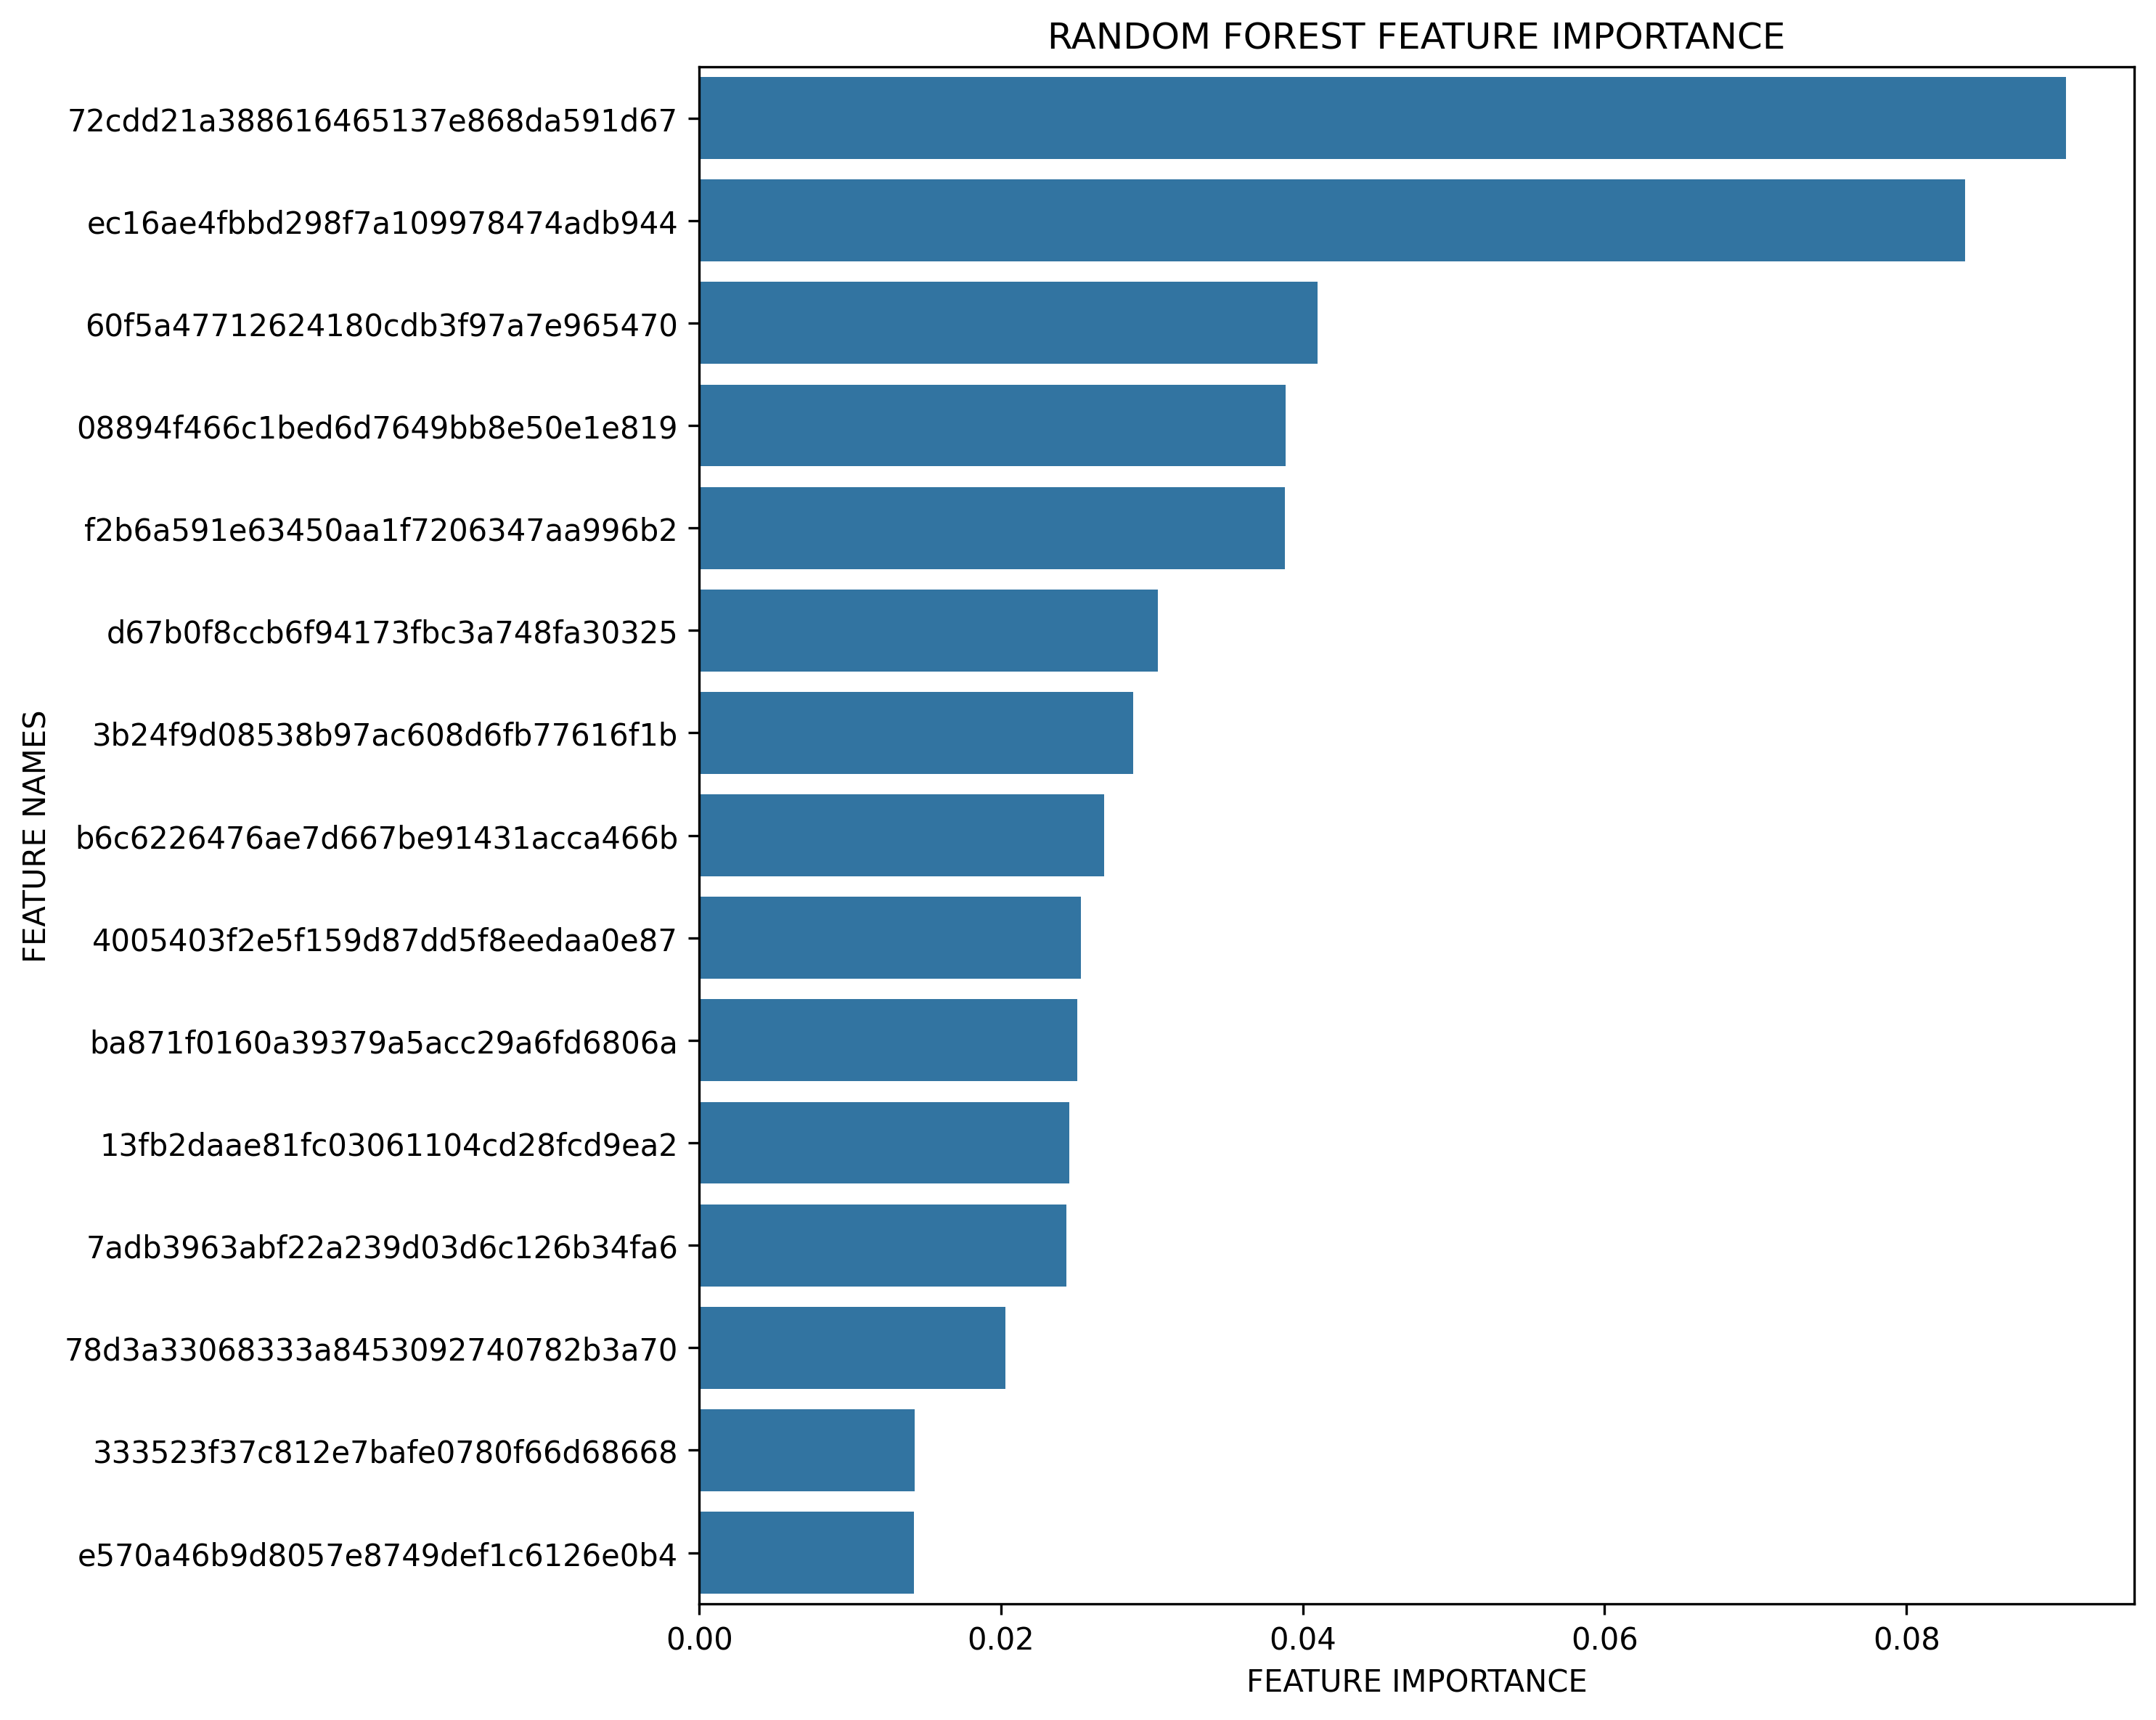

In [8]:
plot_feature_importance(clf_br.feature_importances_,otu_names_br,15,'RANDOM FOREST ', file_name="Union_S19_W20_gills")

## Digestive gland:

 All sets
>>> Xs19               precision    recall  f1-score   support

          -1       1.00      0.90      0.95        10
           1       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20
 
ROC AUC= 0.9500000000000001 
##########
Confusion matrix, without normalization
[[ 9  1]
 [ 0 10]]


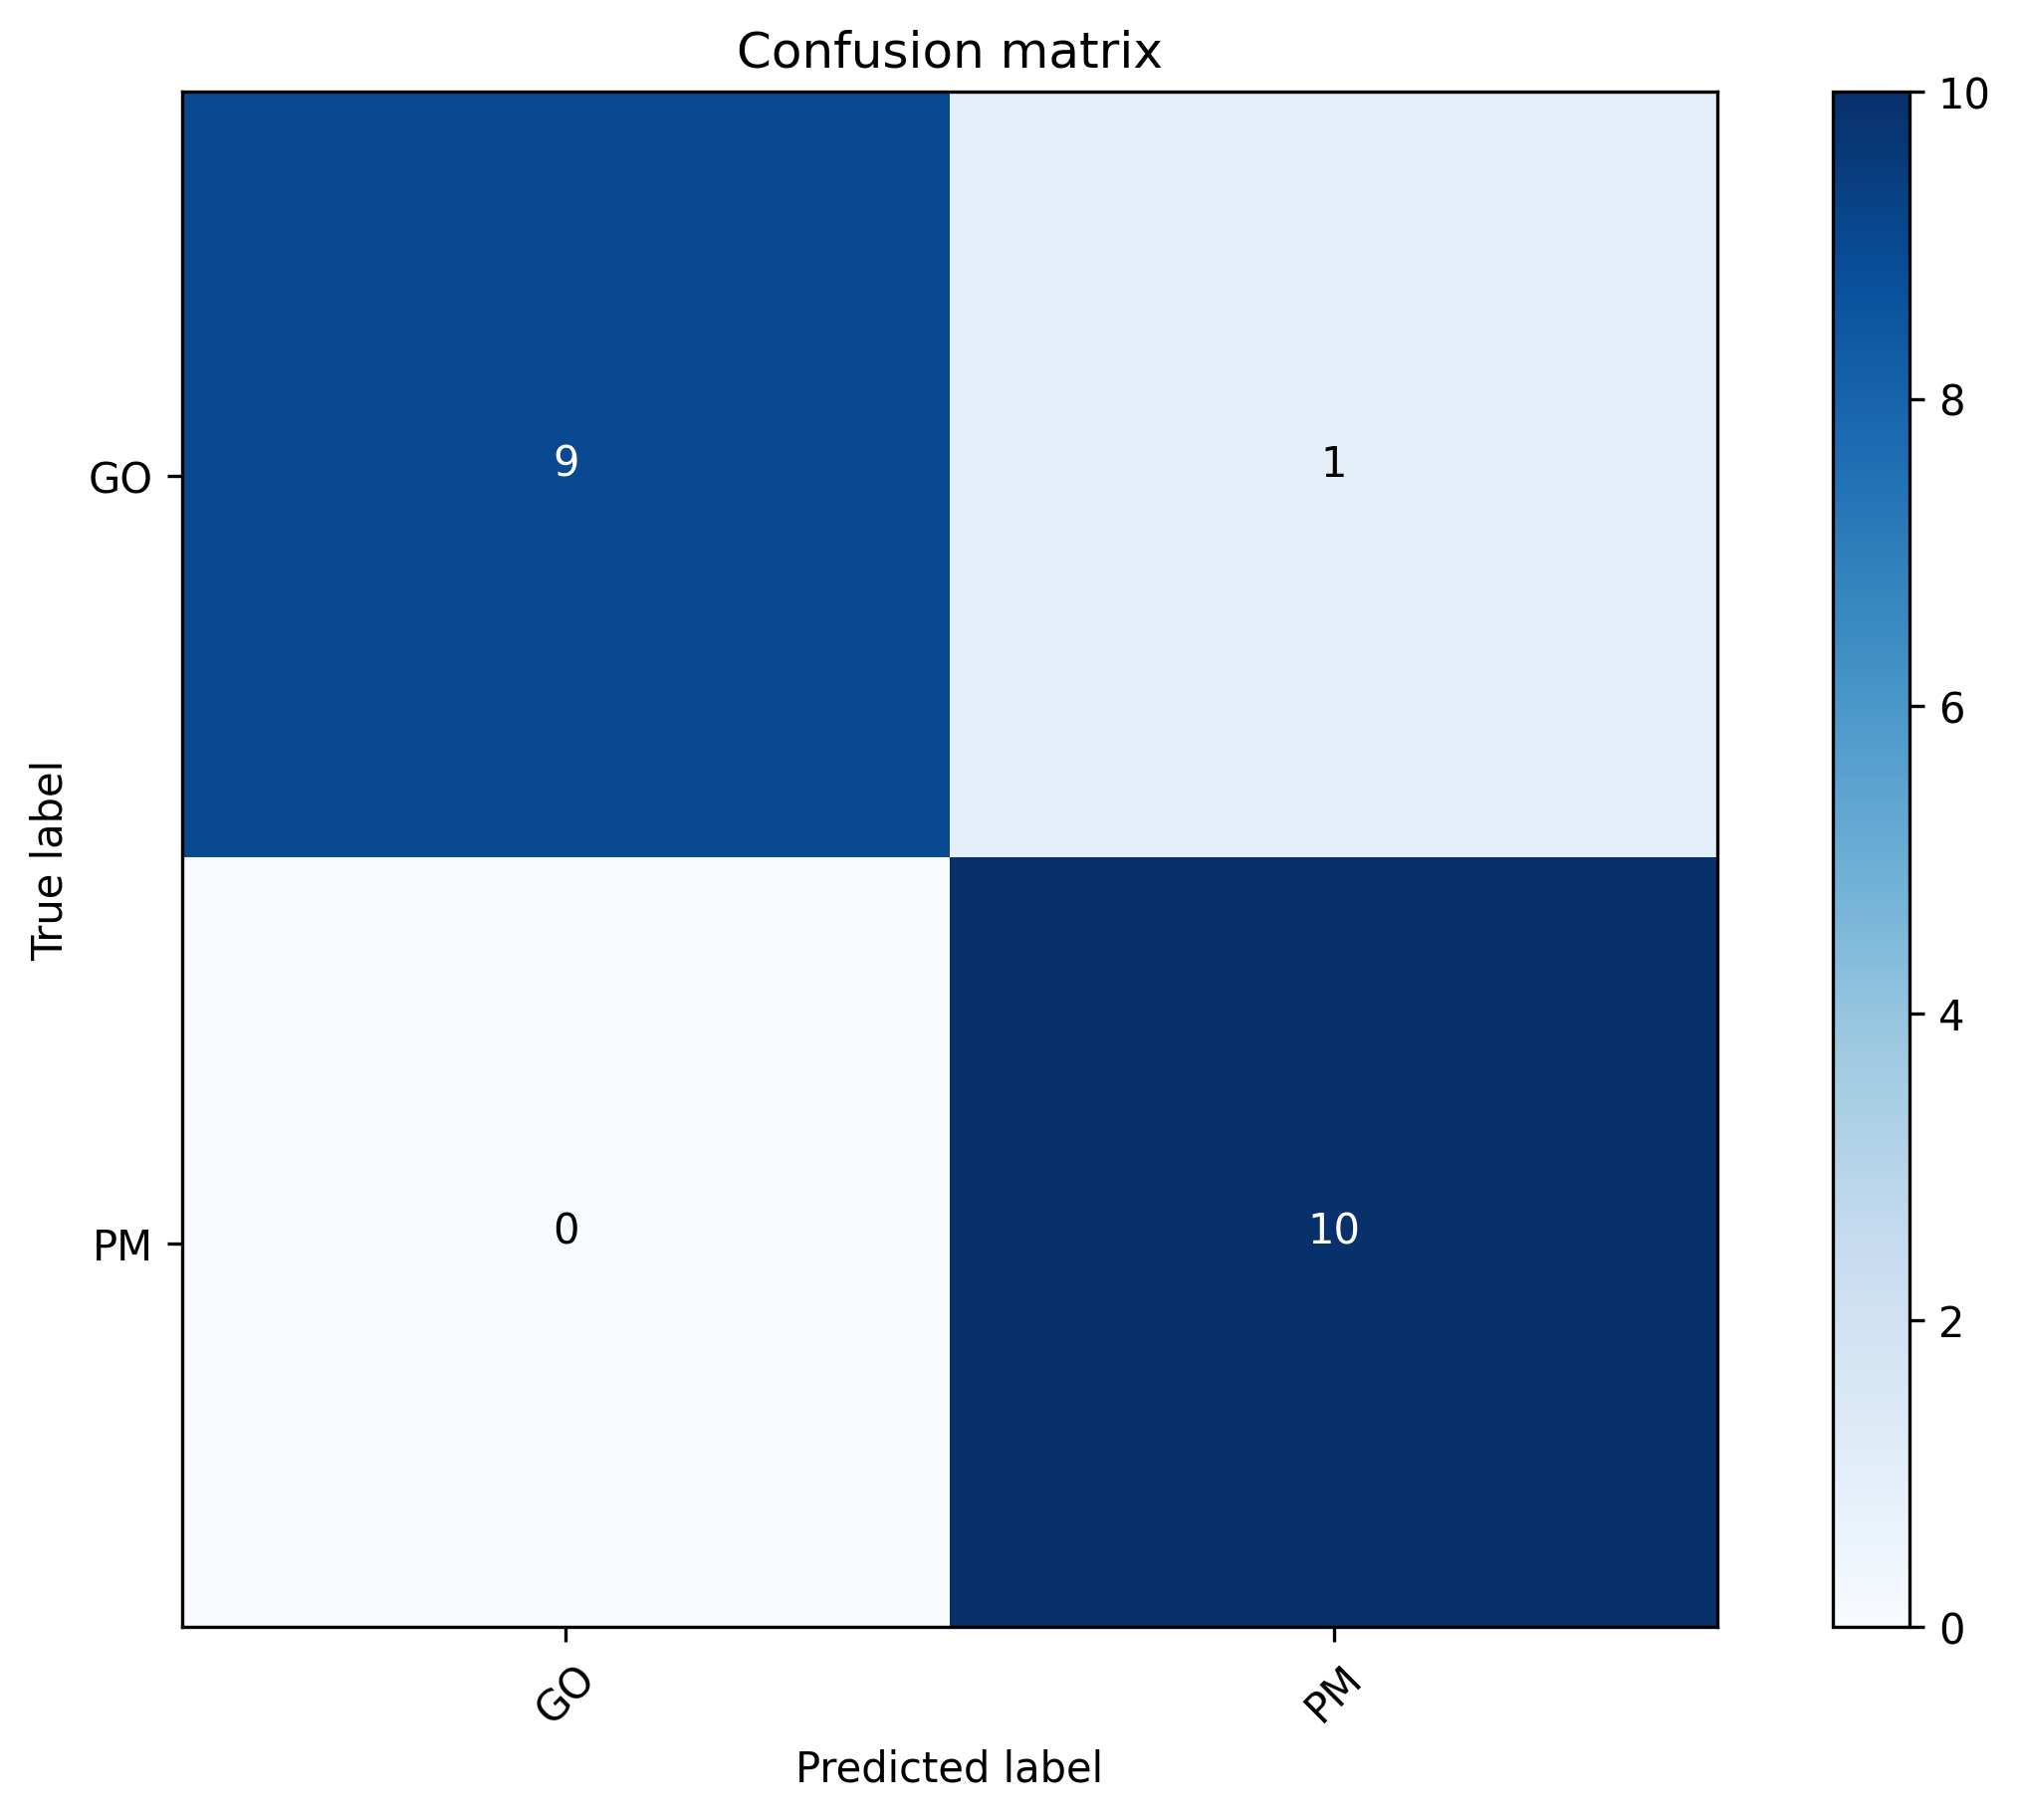

In [9]:
ne_gh, md_gh = abest_gh # best paramenters
clf_gh = clf_gh = RandomForestClassifier(n_estimators=ne_gh, max_depth=md_gh)

np.random.seed(42)
clf_gh.fit(XL_gh,yL_gh)

print ("="*20,"\n","All sets\n","="*20) 
p_gh_proba = clf_gh.predict_proba(XV_gh) 
p_gh = clf_gh.predict(XV_gh)

#pred_gh = np.argmax( np.vstack([np.sum(p_gh[:,[0,1]],axis=1), np.sum(p_gh[:,[2,3]],axis=1)]).T, axis=1)
#obs2_gh = np.where(np.array(yV_gh)<=2,0,1)



print(">>> Xs19",classification_report(yV_gh,p_gh),
          #"\nK-score=",cohen_kappa_score(yV_gh,p_gh),
          "\nROC AUC=", roc_auc_score(yV_gh,p_gh),
          "\n"+"#"*10)
cnf_matrix_gh = confusion_matrix(yV_gh, p_gh)
plot_cm(cnf_matrix_gh, classes=loc_name, output_pdf_path="GhDig_pred_first_year.pdf")

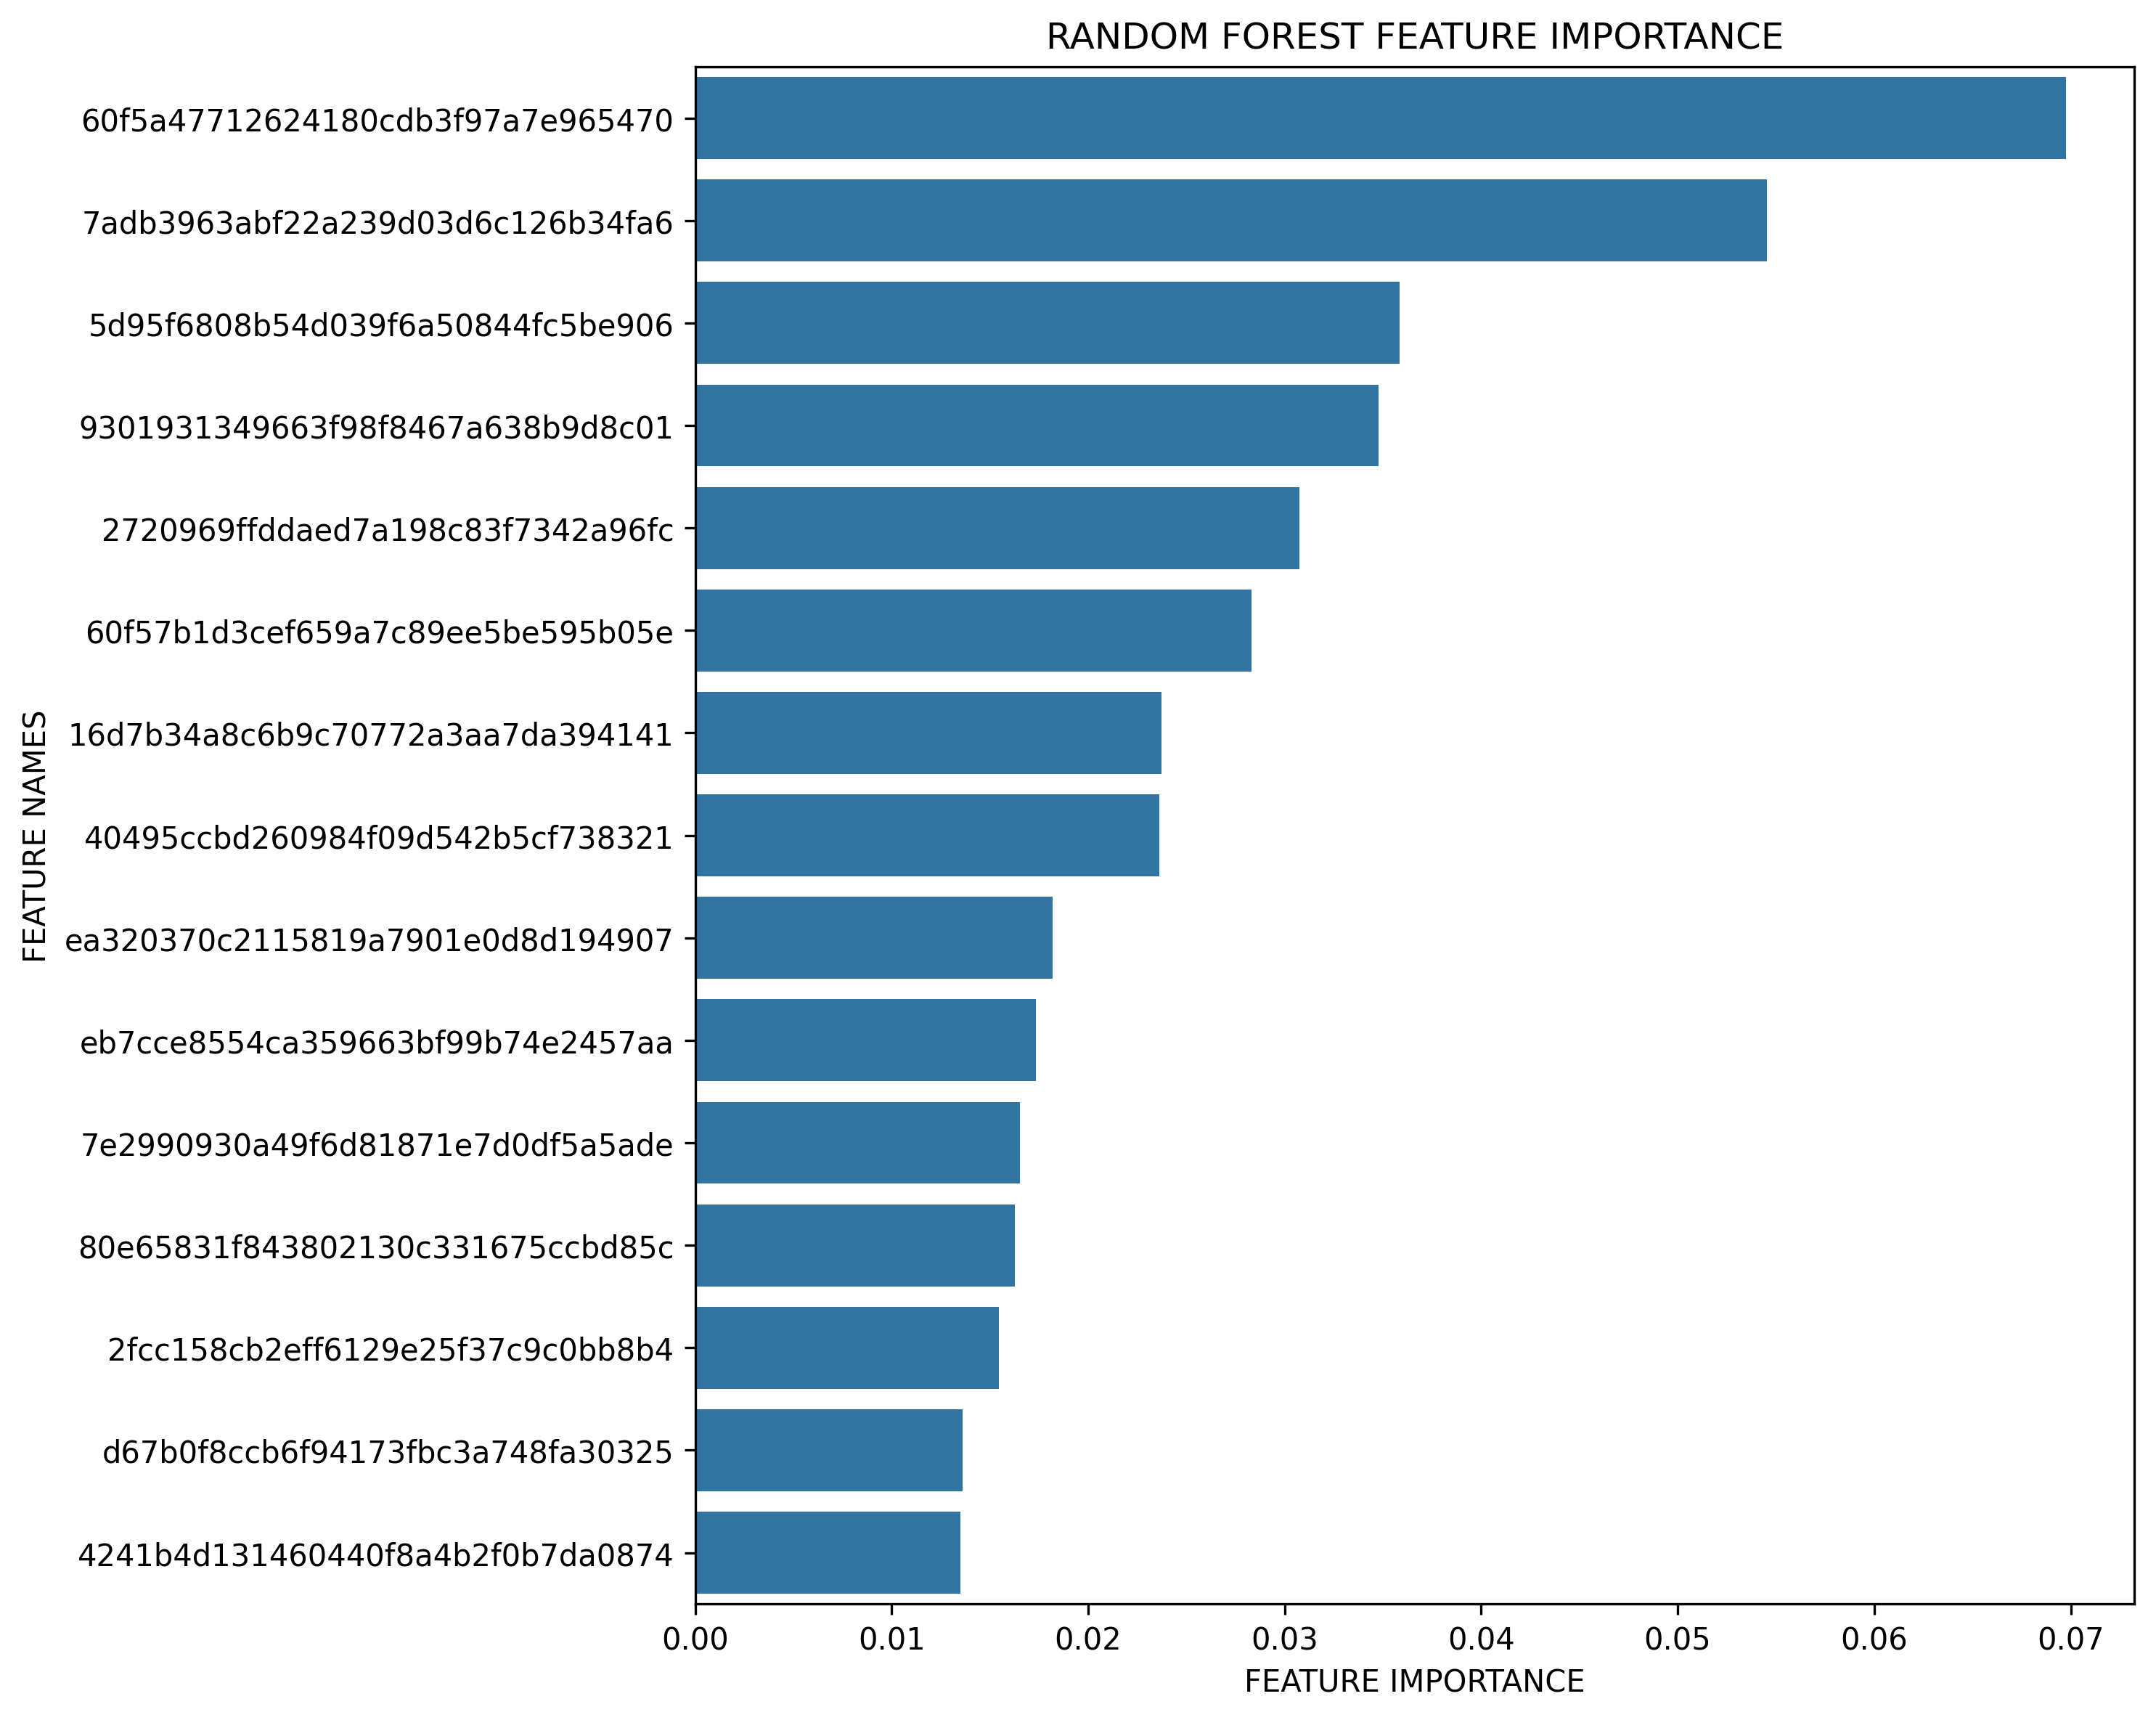

In [10]:
plot_feature_importance(clf_gh.feature_importances_,otu_names_gh,15,'RANDOM FOREST ', file_name="Union_S19_W20_hepatop")

## Sum probabilities to obtain one consensus prediction:

>>> Xs18               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20
 
ROC AUC= 1.0 
##########
Confusion matrix, without normalization
[[10  0]
 [ 0 10]]


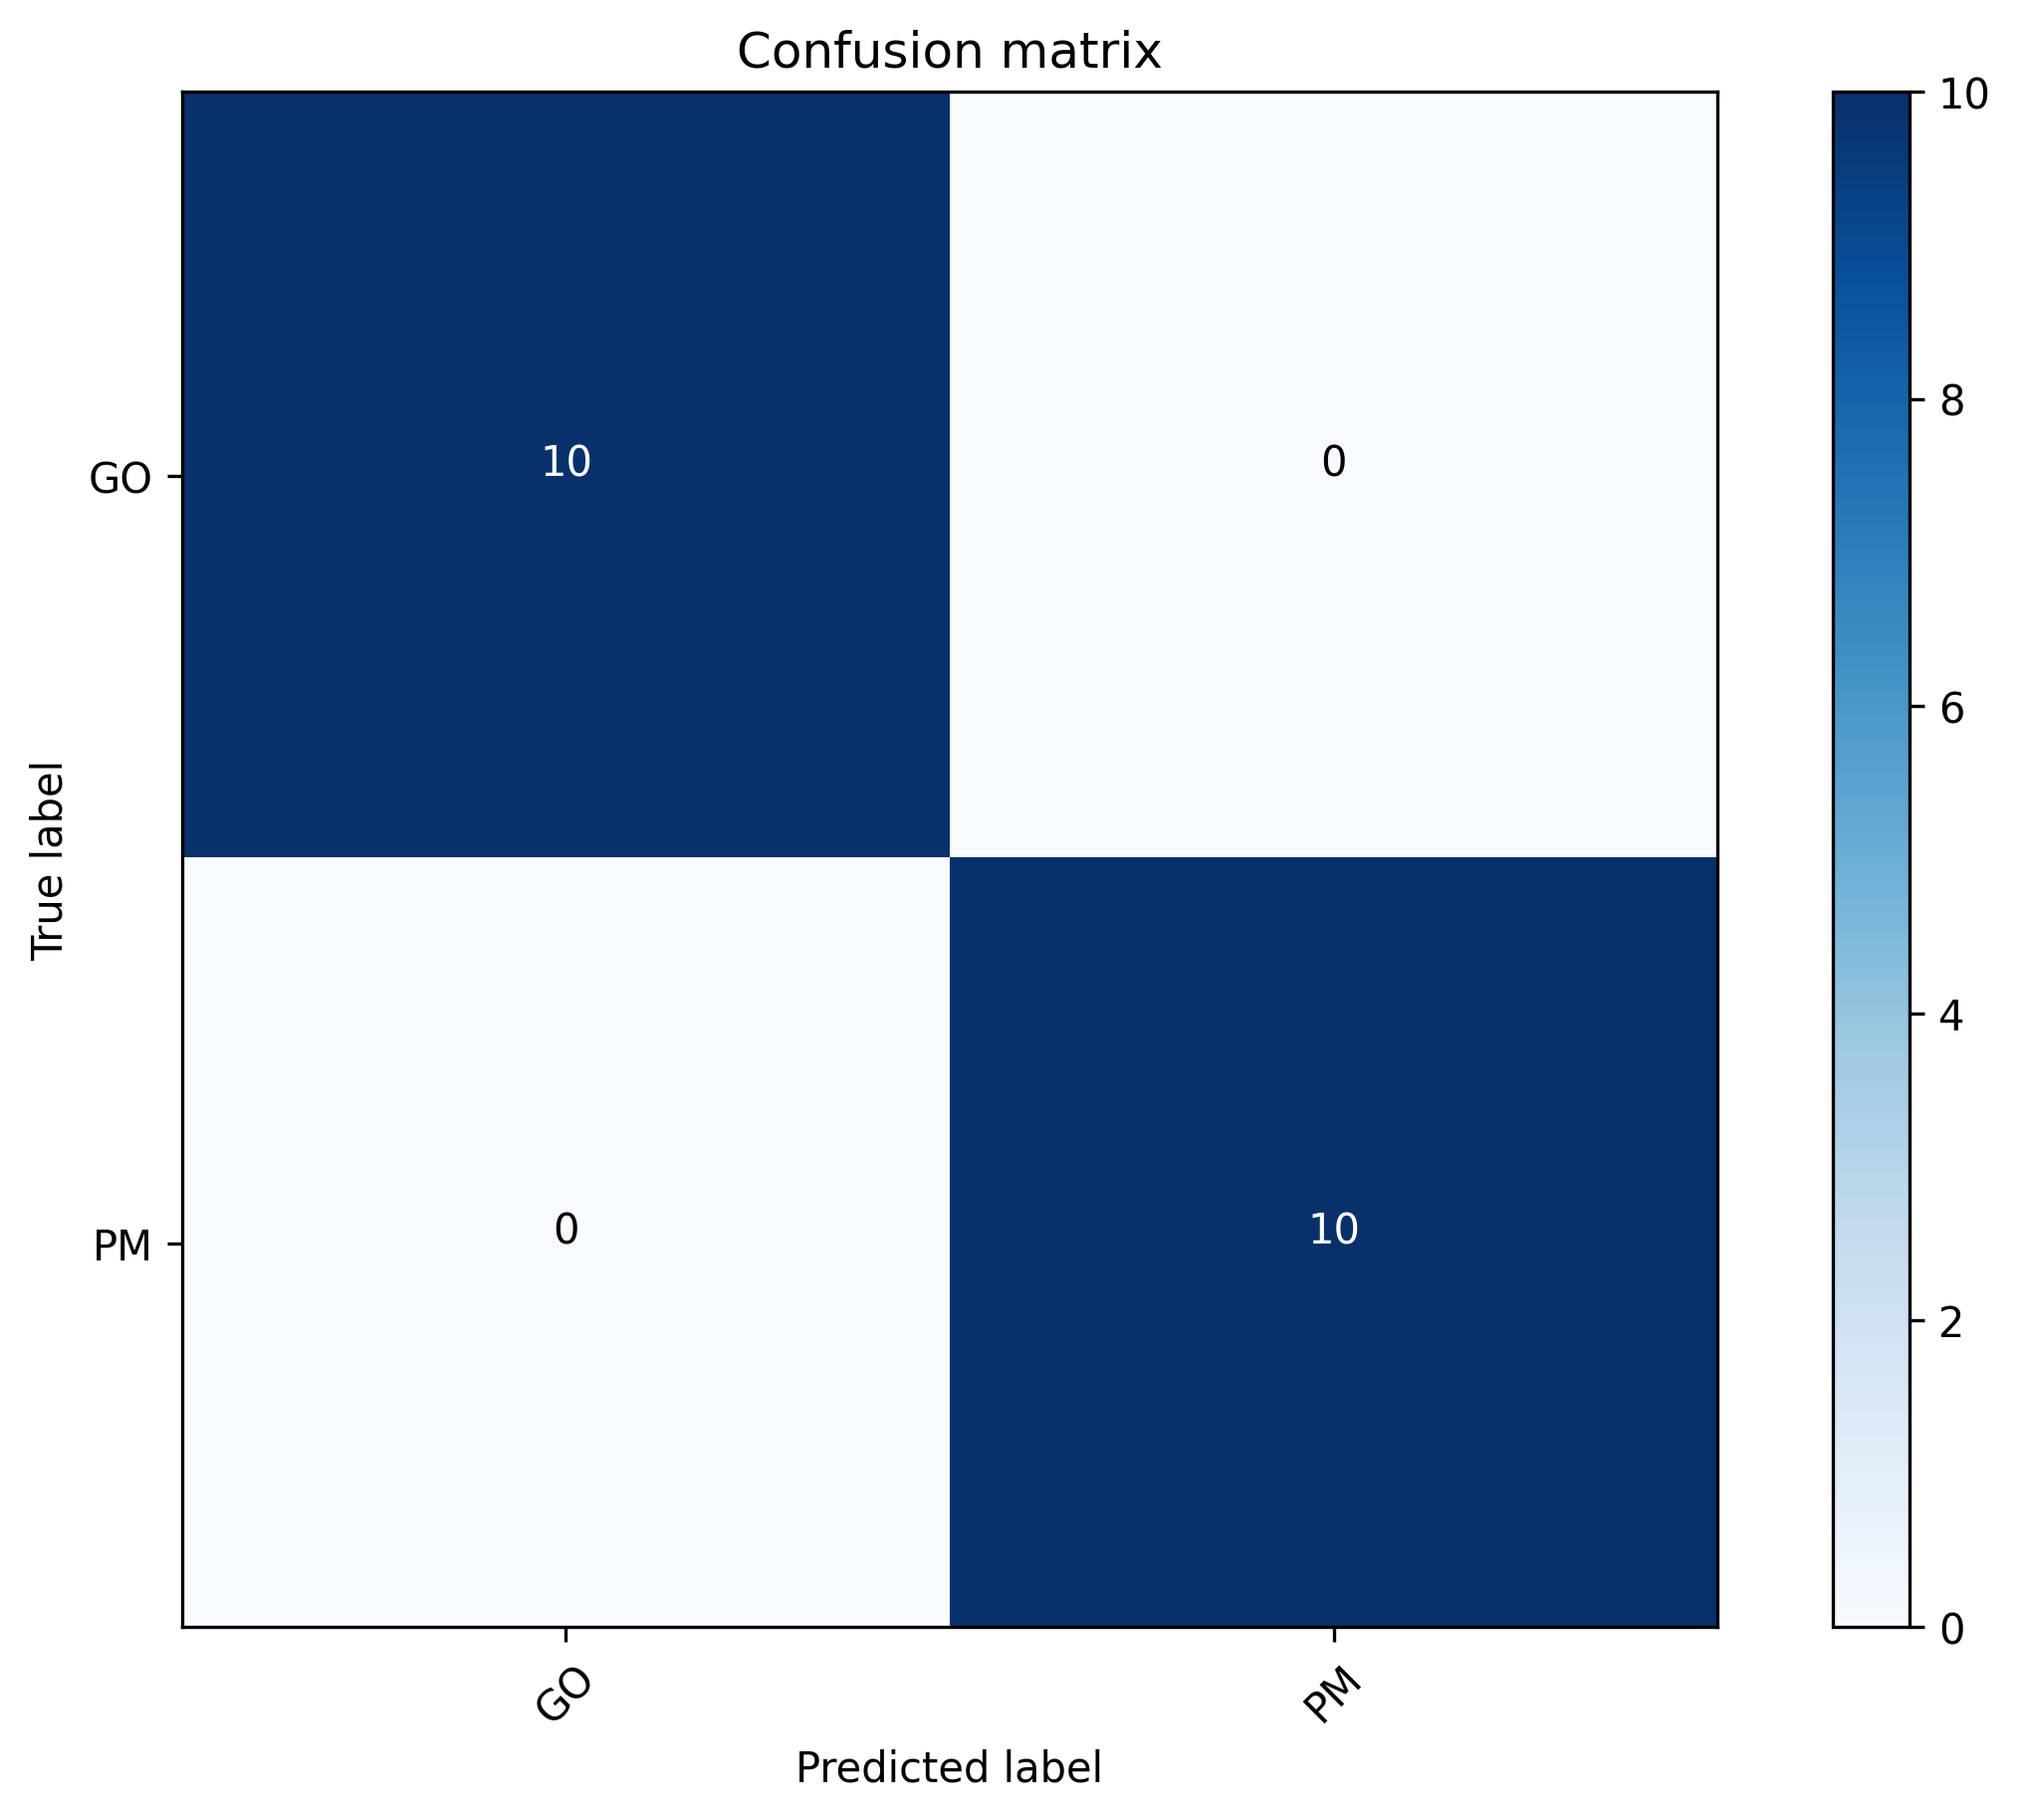

In [11]:
# Summing probabilities from independent predictions:
p_global = p_gh_proba + p_br_proba
#pred_global = np.argmax( np.vstack([np.sum(p_global[:,[0,1]],axis=1), np.sum(p_global[:,[2,3]],axis=1)]).T, axis=1)
somme = np.argmax(p_global, axis=1)
pred_global = np.where(np.array(somme)>0,1,-1) # Relabel according to the scheme polluted -1; unpolluted +1.
#obs2 = np.where(np.array(yV_br)<=2,0,1)

# Confusion matrix of global prediction:
print(">>> Xs18",classification_report(yV_br,pred_global),
          #"\nK-score=",cohen_kappa_score(yV_br,pred_global),
          "\nROC AUC=", roc_auc_score(yV_br,p_br),
          "\n"+"#"*10)
cnf_matrix = confusion_matrix(yV_br, pred_global)
plot_cm(cnf_matrix, classes=loc_name, output_pdf_path="Consensus_pred_first_year.pdf")

---------------------------------------
# Fit using first year data, predict second year data

## Gills:

 All sets
>>> Xs18               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20
 
ROC AUC= 1.0 
##########
Confusion matrix, without normalization
[[10  0]
 [ 0 10]]


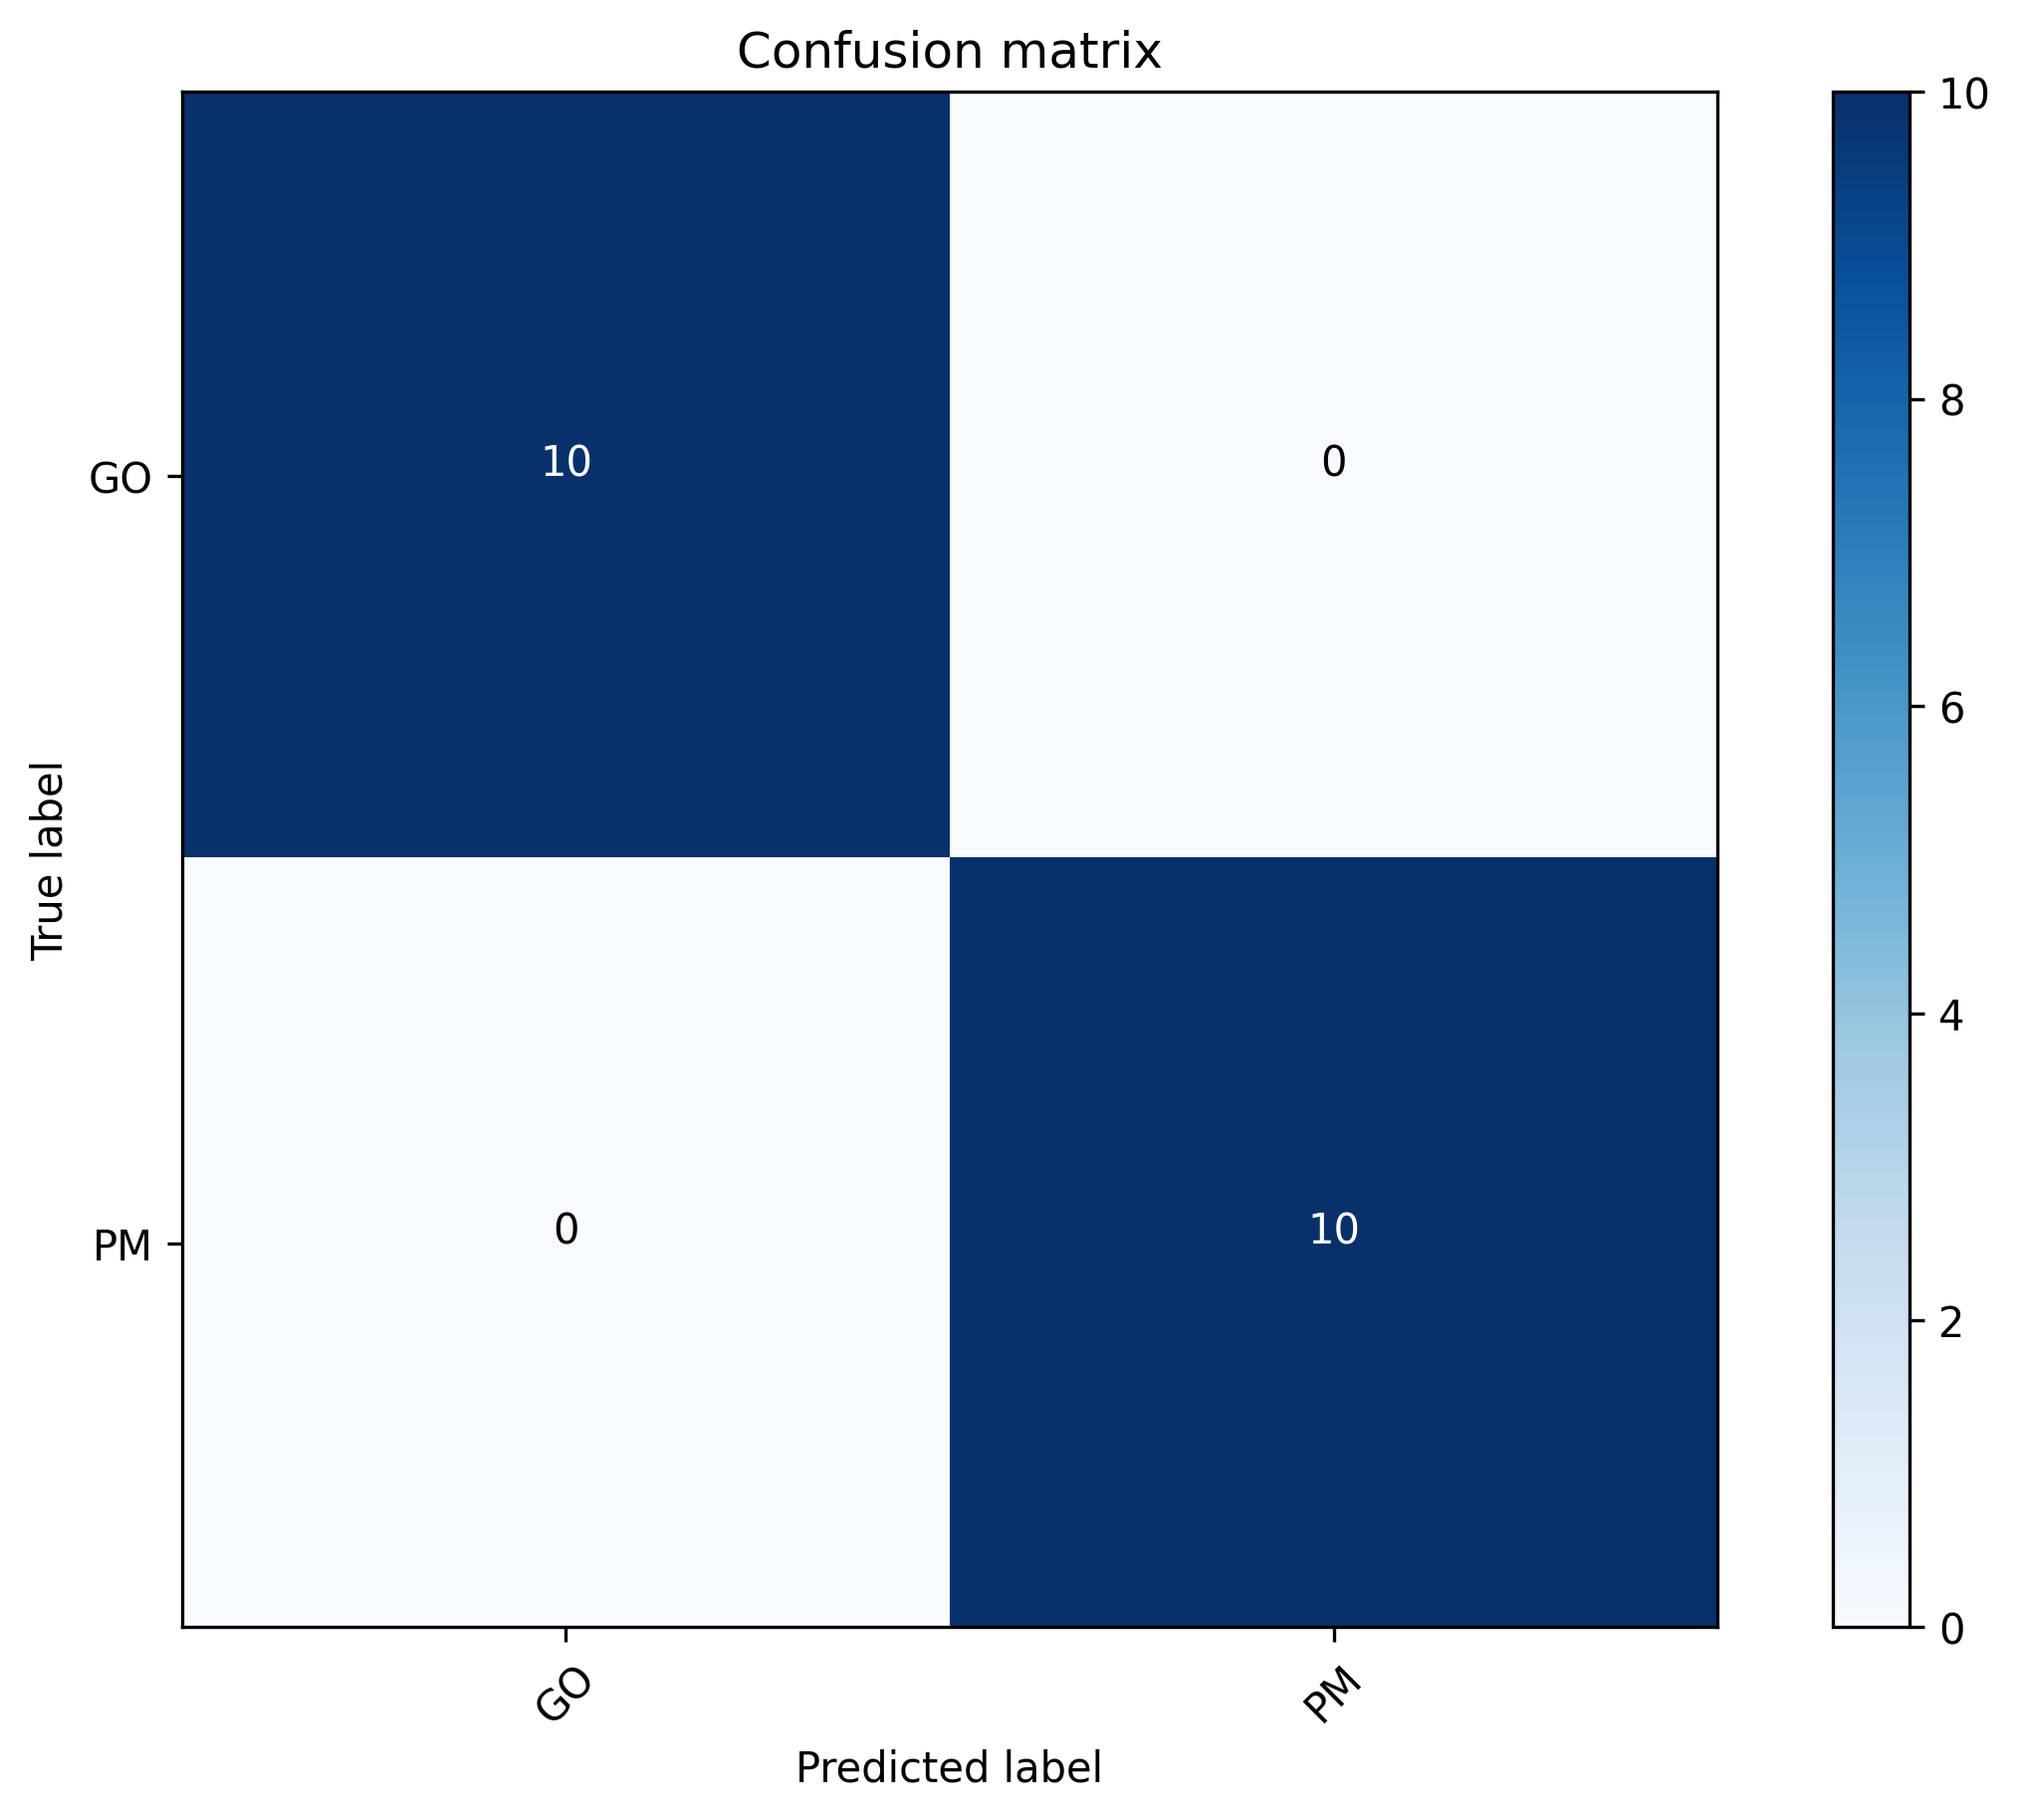

In [12]:
ne_br,md_br = abest_br 
clf_br = clf_br = RandomForestClassifier(n_estimators=ne_br, max_depth=md_br)

np.random.seed(42)
clf_br.fit(XV_br,yV_br)

print ("="*20,"\n","All sets\n","="*20) 
p_br_proba = clf_br.predict_proba(XL_br) 
p_br = clf_br.predict(XL_br)
#pred_br = np.argmax( np.vstack([np.sum(p_br[:,[0,1]],axis=1), np.sum(p_br[:,[2,3]],axis=1)]).T, axis=1)
#obs2_br = np.where(np.array(yL_br)<=2,0,1)


print(">>> Xs18",classification_report(yL_br,p_br),
          #"\nK-score=",cohen_kappa_score(yL_br,p_br),
          "\nROC AUC=", roc_auc_score(yL_br,p_br),
          "\n"+"#"*10)
cnf_matrix_br = confusion_matrix(yL_br,p_br)
plot_cm(cnf_matrix_br, classes=loc_name)

## Digestive gland:

 All sets
>>> Xs18               precision    recall  f1-score   support

          -1       1.00      0.80      0.89        10
           1       0.83      1.00      0.91        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20
 
ROC AUC= 0.9 
##########
Confusion matrix, without normalization
[[ 8  2]
 [ 0 10]]


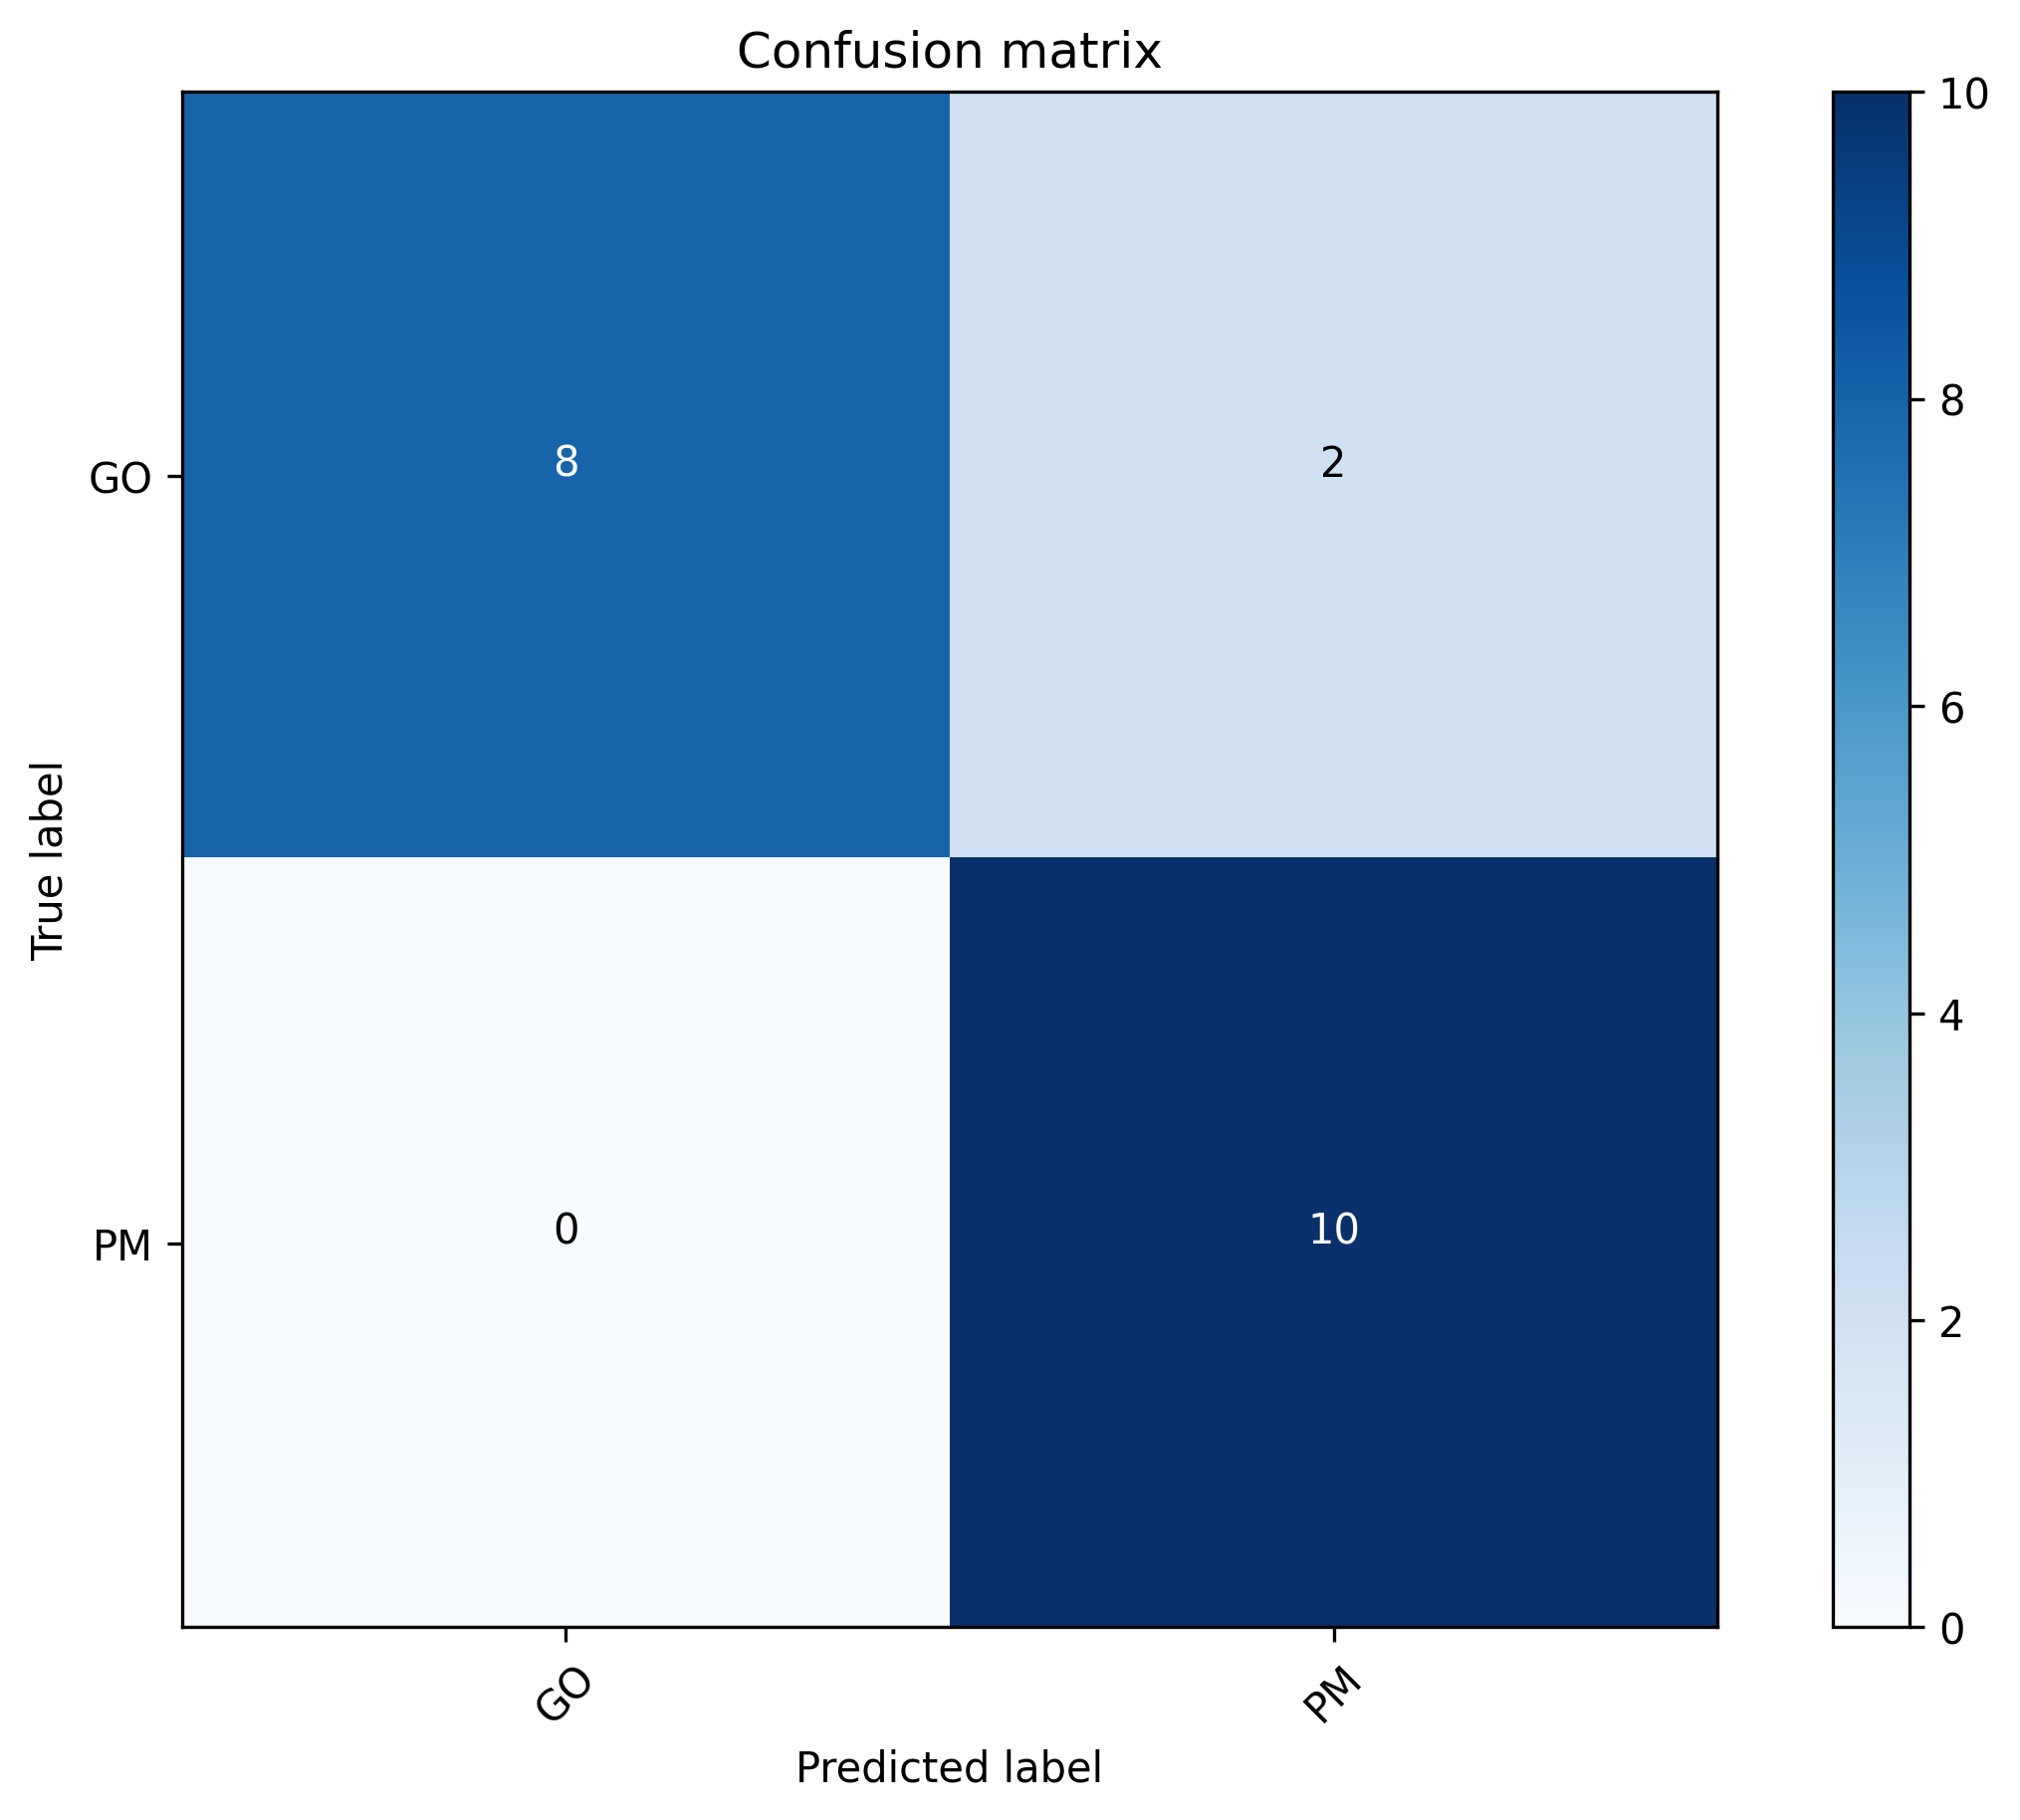

In [13]:
ne_gh,md_gh = abest_gh 
clf_gh = clf_gh = RandomForestClassifier(n_estimators=ne_gh, max_depth=md_gh)

np.random.seed(42)
clf_gh.fit(XV_gh,yV_gh)

print ("="*20,"\n","All sets\n","="*20) 
p_gh_proba = clf_gh.predict_proba(XL_gh)
p_gh = clf_gh.predict(XL_gh)

#pred_gh = np.argmax( np.vstack([np.sum(p_gh[:,[0,1]],axis=1), np.sum(p_gh[:,[2,3]],axis=1)]).T, axis=1)
#obs2_gh = np.where(np.array(yL_gh)<=2,0,1)


print(">>> Xs18",classification_report(yL_gh,p_gh),
          #"\nK-score=",cohen_kappa_score(yL_gh,p_gh),
      "\nROC AUC=", roc_auc_score(yL_gh,p_gh),
          "\n"+"#"*10)
cnf_matrix_gh = confusion_matrix(yL_gh, p_gh)
plot_cm(cnf_matrix_gh, classes=loc_name)

## Sum probabilities to obtain one consensus prediction:

>>> Xs18               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20
 
ROC AUC= 1.0 
##########
Confusion matrix, without normalization
[[10  0]
 [ 0 10]]


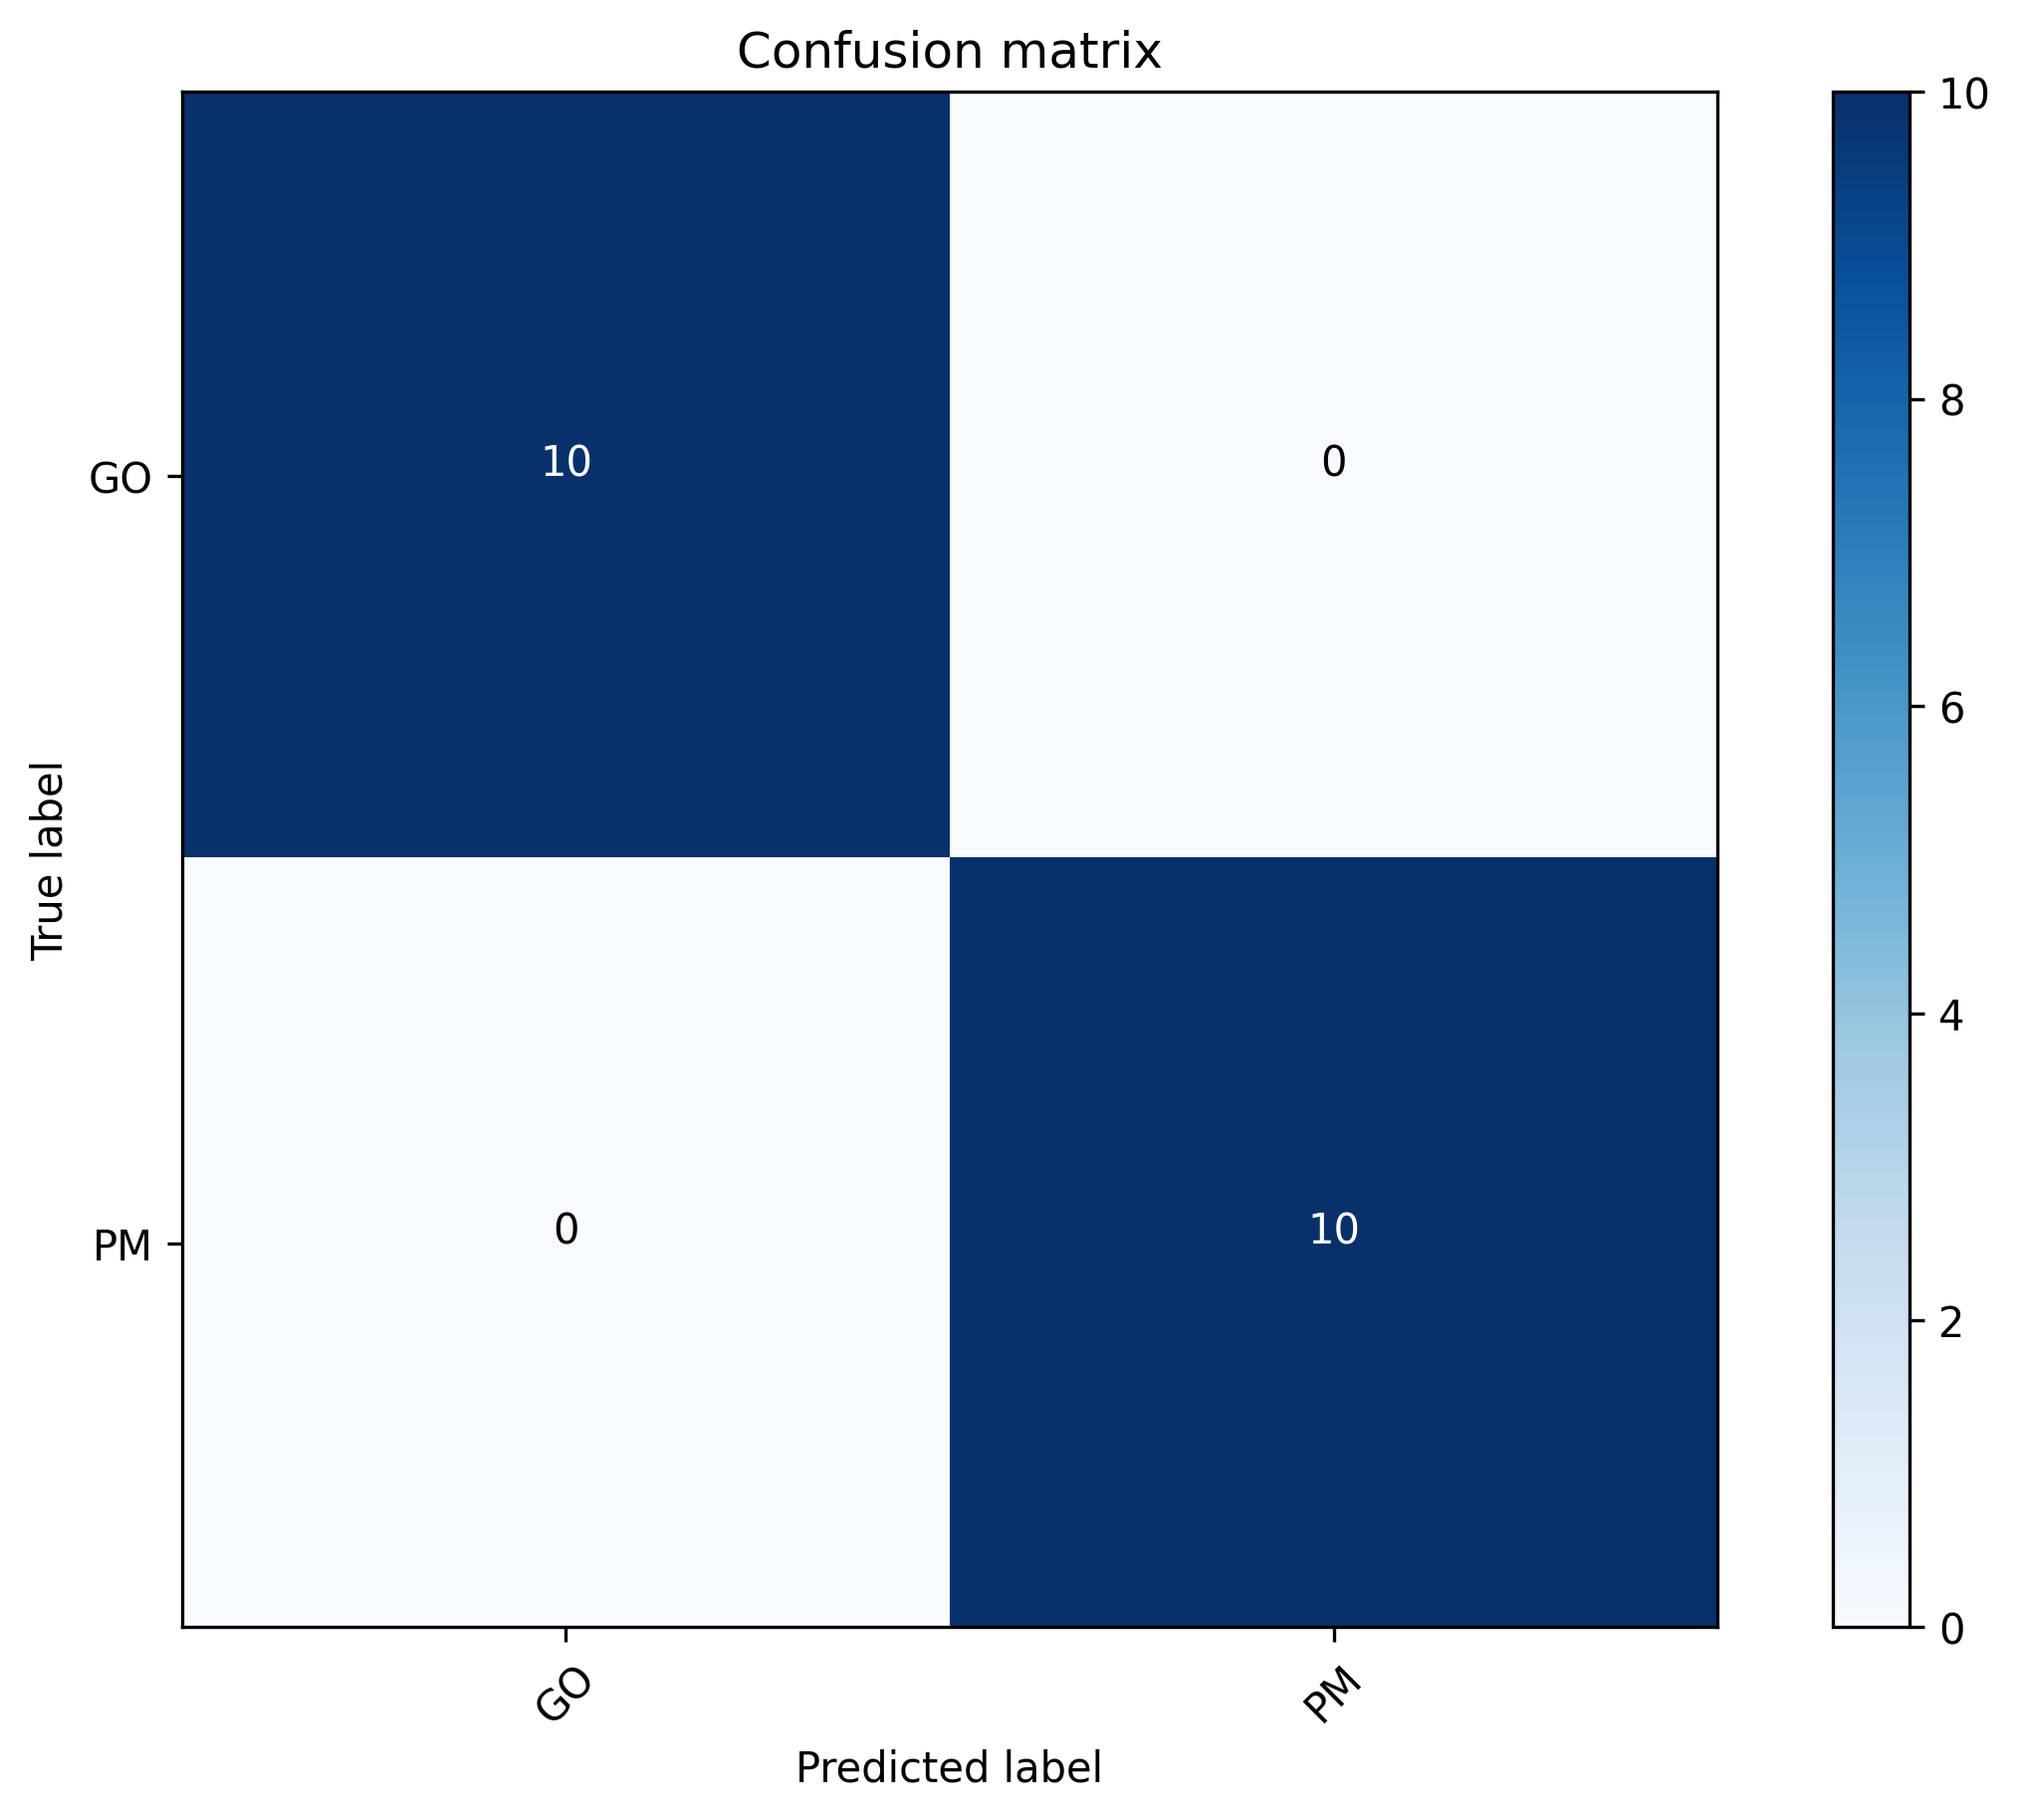

In [14]:
# Summing probabilities from independent predictions:
p_global = p_gh_proba + p_br_proba
#pred_global = np.argmax( np.vstack([np.sum(p_global[:,[0,1]],axis=1), np.sum(p_global[:,[2,3]],axis=1)]).T, axis=1)
somme = np.argmax(p_global, axis=1)
pred_global = np.where(np.array(somme)>0,1,-1) # Relabel according to the scheme polluted -1; unpolluted +1.
#obs2 = np.where(np.array(yV_br)<=2,0,1)

# Confusion matrix of global prediction:
print(">>> Xs18",classification_report(yL_br,pred_global),
          #"\nK-score=",cohen_kappa_score(yV_br,pred_global),
          "\nROC AUC=", roc_auc_score(yL_br,p_br),
          "\n"+"#"*10)
cnf_matrix = confusion_matrix(yL_br, pred_global)
plot_cm(cnf_matrix, classes=loc_name)

----------------------------

In [15]:
#from sinfo import sinfo
#sinfo()

Test summing probabilities:

In [16]:
#from objbrowser import browse
#browse(clf)